In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.14
3.11.6
1.11.3


In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.02*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span/2,y_span/2] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

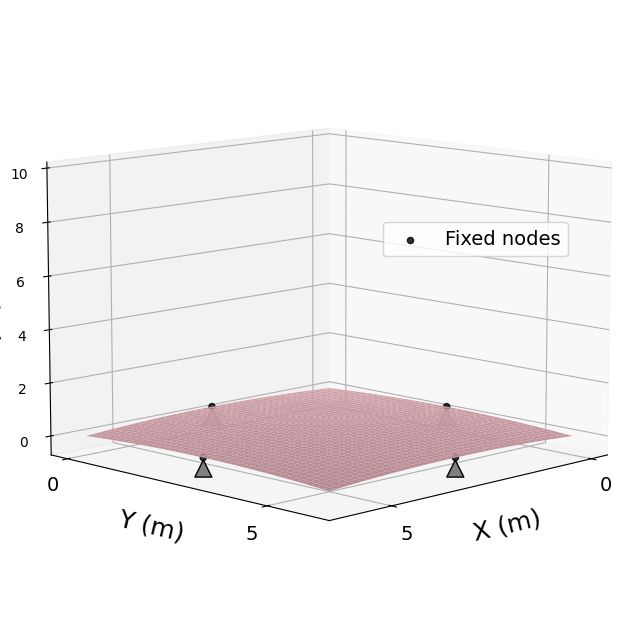

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

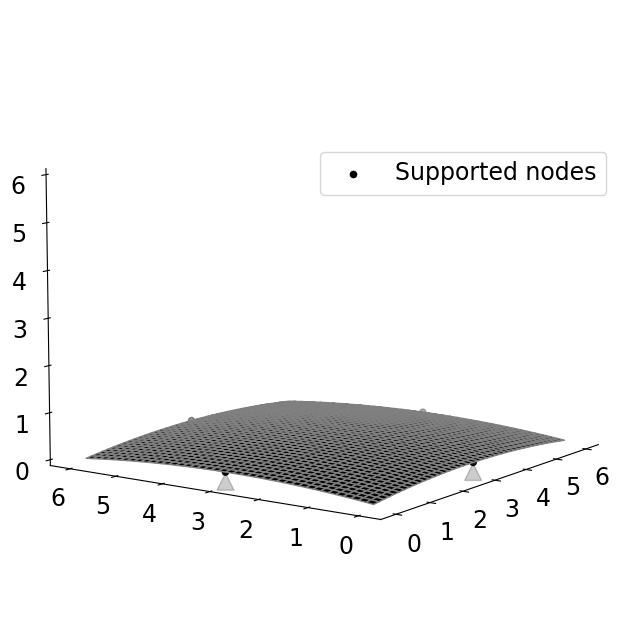

In [4]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -145)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

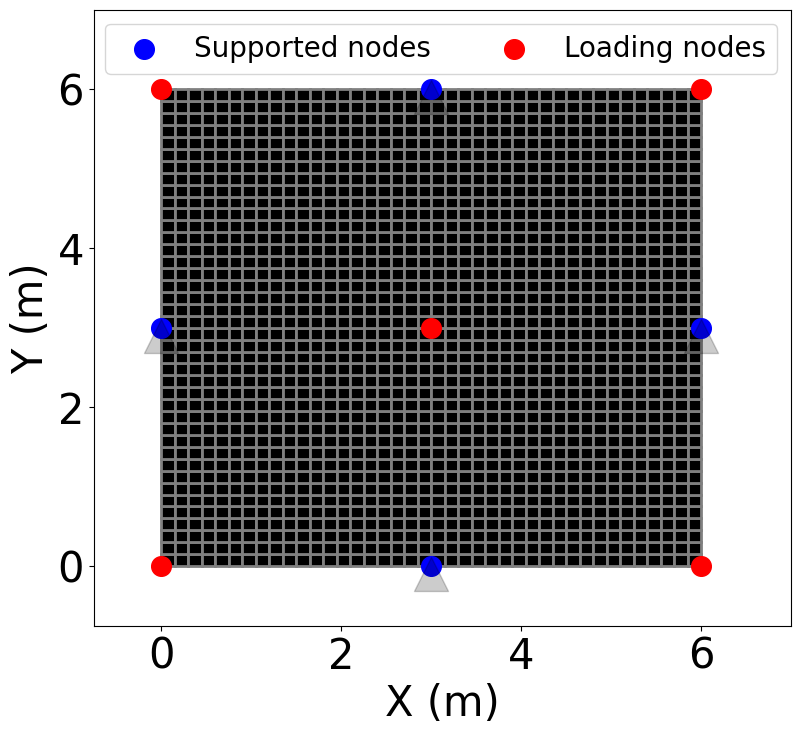

In [5]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [6]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [7]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [8]:
B_ij.shape

(1681, 1681)

In [9]:
n_node/2

840.5

In [10]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

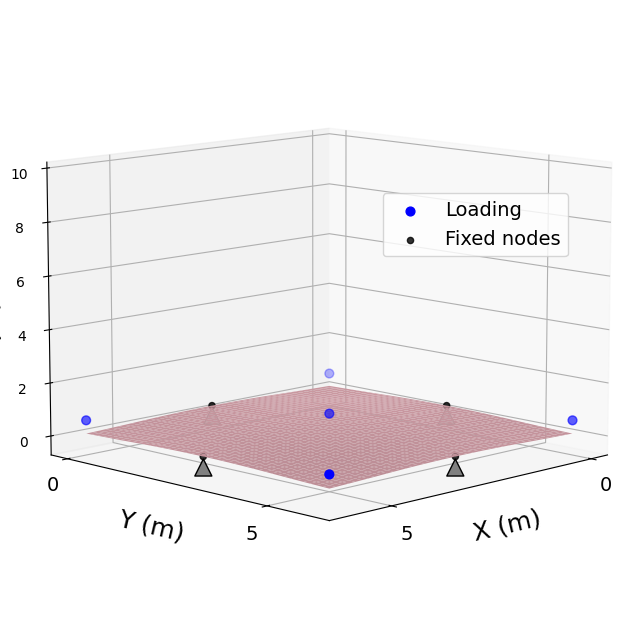

In [11]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [12]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [13]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [14]:
B_ij_shell.shape

(1600, 1600)

In [15]:
#W(A): total volume
def coeff_E(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**7*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

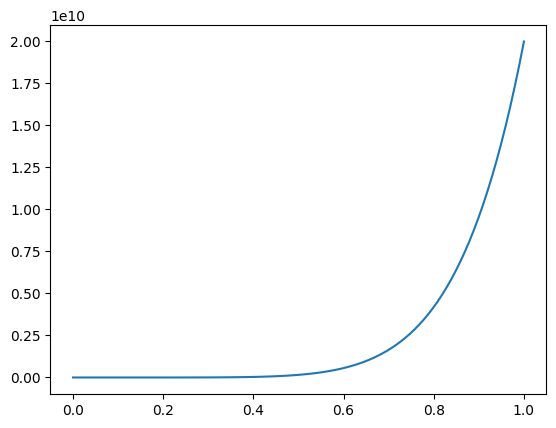

In [16]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [17]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




2024-04-28 15:03:39.737214: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:462] TfrtCpuClient created.
2024-04-28 15:03:39.859366: I external/xla/xla/service/service.cc:168] XLA service 0x55ca9c3e75a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 15:03:39.859383: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-28 15:03:39.859588: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:633] Using BFC allocator.
2024-04-28 15:03:39.859614: I external/xla/xla/pjrt/gpu/gpu_helpers.cc:105] XLA backend allocating 63875432448 bytes on device 0 for BFCAllocator.


In [18]:
model.solve()

In [19]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [20]:
sso_model.parameter_values.shape

(3281,)

In [21]:
sso_model.eleparameters_values.shape

(1600,)

In [22]:
C_hist = []
mu_sum_list =[]
def objective_filter(x,sso_model=sso_model):
    '''
    Design parameters:
    node params: normalized control point (pre filtered)
    ele params: pre-filtered mu
    '''
    node_params = x[:sso_model.nodeparameters_values.shape[0]]
    ele_params = x[sso_model.nodeparameters_values.shape[0]:]
    
    #Normalized pt - Unnormalized Control pt - filtered actual geometry pt
    p = zs.copy()
    p[design_nodes]= og_p(node_params) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    sso_model.update_nodeparameter(z) # Update the model
    
    #pre-filtered mu
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu) #Penalized Young's modulus
    sso_model.update_eleparameter(E_step) # Update the model
    
    #JAX-SSO
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    print("{}th iteration, C = {} ".format(len(C_hist),C))
    mu_sum_list.append(np.sum(ele_params))
    
    #Chain rule for final gradient
    sens_node = sens[:sso_model.nodeparameters_values.shape[0]]
    sens_shape = np.asarray((sens_node@B_ij[design_nodes])[design_nodes],dtype=float)
    sens_shape_norm = (sens_shape@jacfwd(og_p)(x[:sso_model.nodeparameters_values.shape[0]]))
    
    sens_ele =sens[sso_model.nodeparameters_values.shape[0]:]
    sens_topo = sens_ele@jacfwd(coeff_E)(B_ij_shell@x[sso_model.nodeparameters_values.shape[0]:])
    sens_topo_final = sens_topo@B_ij_shell
    
    if len(C_hist)%5==0:
        i = len(C_hist)
        print(jnp.sum(ele_params))
        plt_plan(filtered_mu,i)
    return float(C), jnp.hstack((sens_shape_norm,sens_topo_final))

In [23]:
x_ini = jnp.hstack((0.5*np.abs(norm_p(sso_model.nodeparameters_values)),0.1*np.ones(sso_model.eleparameters_values.shape[0])))

In [24]:
objective_filter(x_ini)

1th iteration, C = 2069037049.271218 


(2069037049.271218,
 Array([ 2.46851271e+07,  2.69691346e+07,  2.75890655e+07, ...,
        -1.65122257e+08, -1.87980124e+08, -1.73233538e+08], dtype=float64))

# Implementing MMA

In [25]:
import nlopt

In [26]:
#Nlopt objective and constraints
def f(x,grad):
    res_1,res_2 = objective_filter(x)
    if grad.size>0:
        grad[:] = res_2

    return res_1

#Constraints on volume minimization
def vol(x):
    '''
    Return the volume constraints
    '''
    mu = x[sso_model.nodeparameters_values.shape[0]:] #the density
    return jnp.sum(mu)-0.5*sso_model.eleparameters_values.shape[0]
def fc(x,grad):
    res_1,res_2 = value_and_grad(vol)(x) 
    if grad.size>0:
        grad[:] = res_2

    return float(res_1)

2th iteration, C = 2069037049.3141956 
3th iteration, C = 17332218180.469406 
4th iteration, C = 17332164098.373833 
5th iteration, C = 17331623266.78144 
402.2623567844653


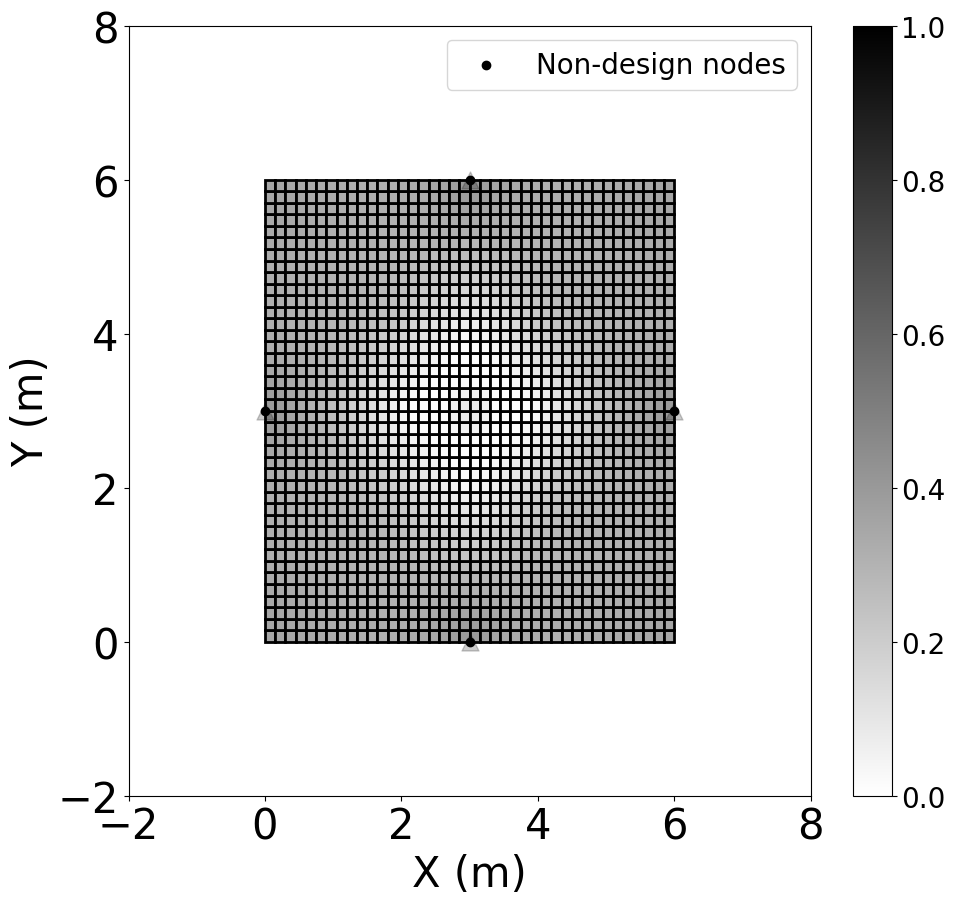

6th iteration, C = 17322707349.682503 
7th iteration, C = 17237320431.492477 
8th iteration, C = 16410922180.701101 
9th iteration, C = 7855242361.111804 
10th iteration, C = 8880790.954036962 
415.49457362983526


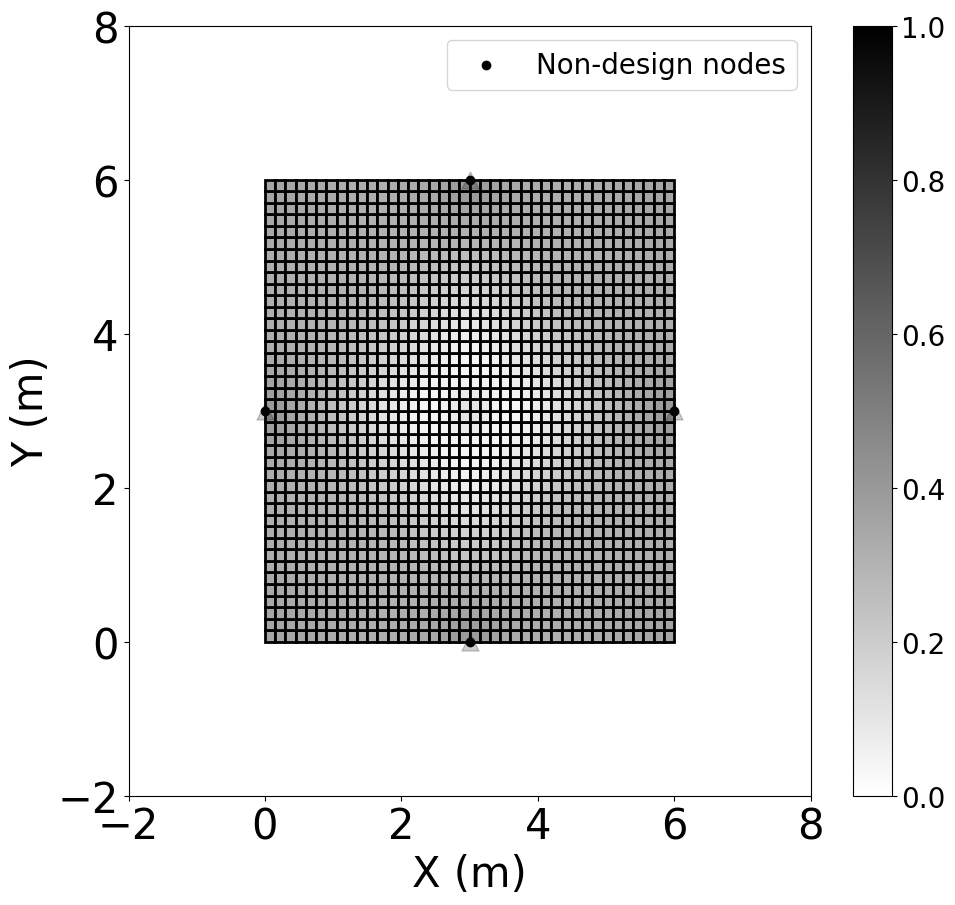

11th iteration, C = 634051.8246669689 
12th iteration, C = 619845.3925683516 
13th iteration, C = 510622.5897864964 
14th iteration, C = 280859.99139787245 
15th iteration, C = 256736.4782687853 
422.7205811364129


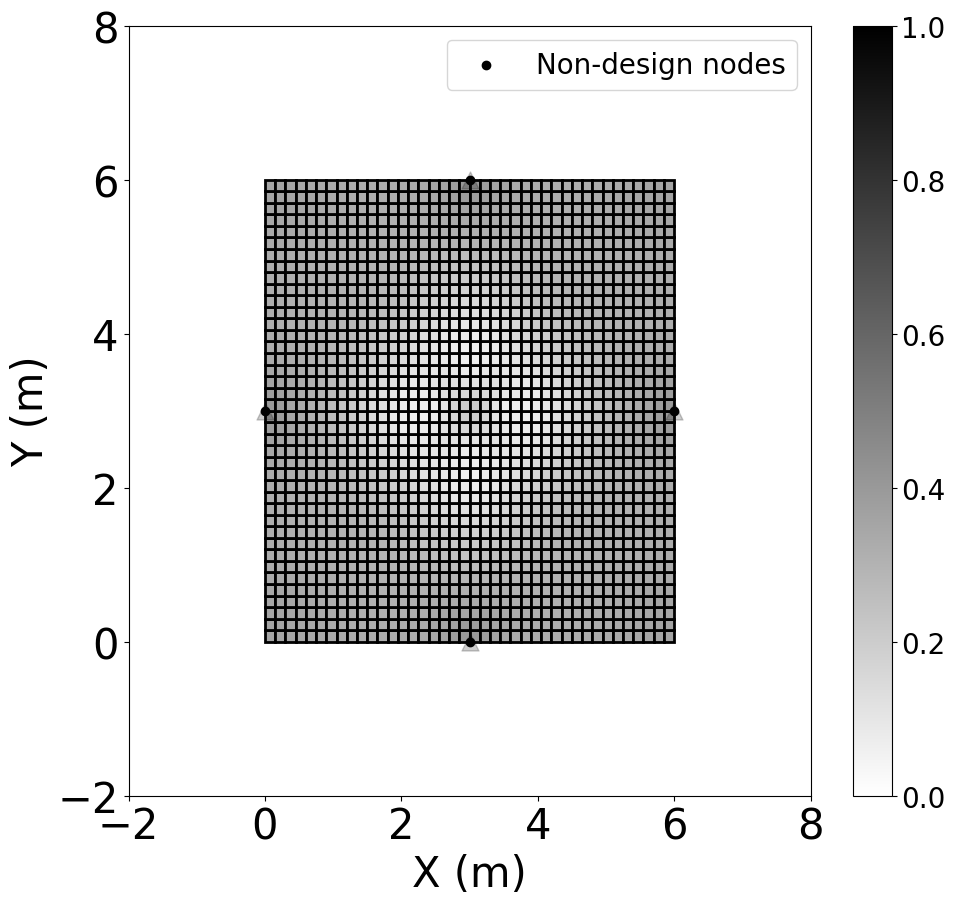

16th iteration, C = 120288.71930176145 
17th iteration, C = 4537.754344589248 
18th iteration, C = 4238.929061864168 
19th iteration, C = 1977.3681883042473 
20th iteration, C = 187.73294383948536 
638.4482556649434


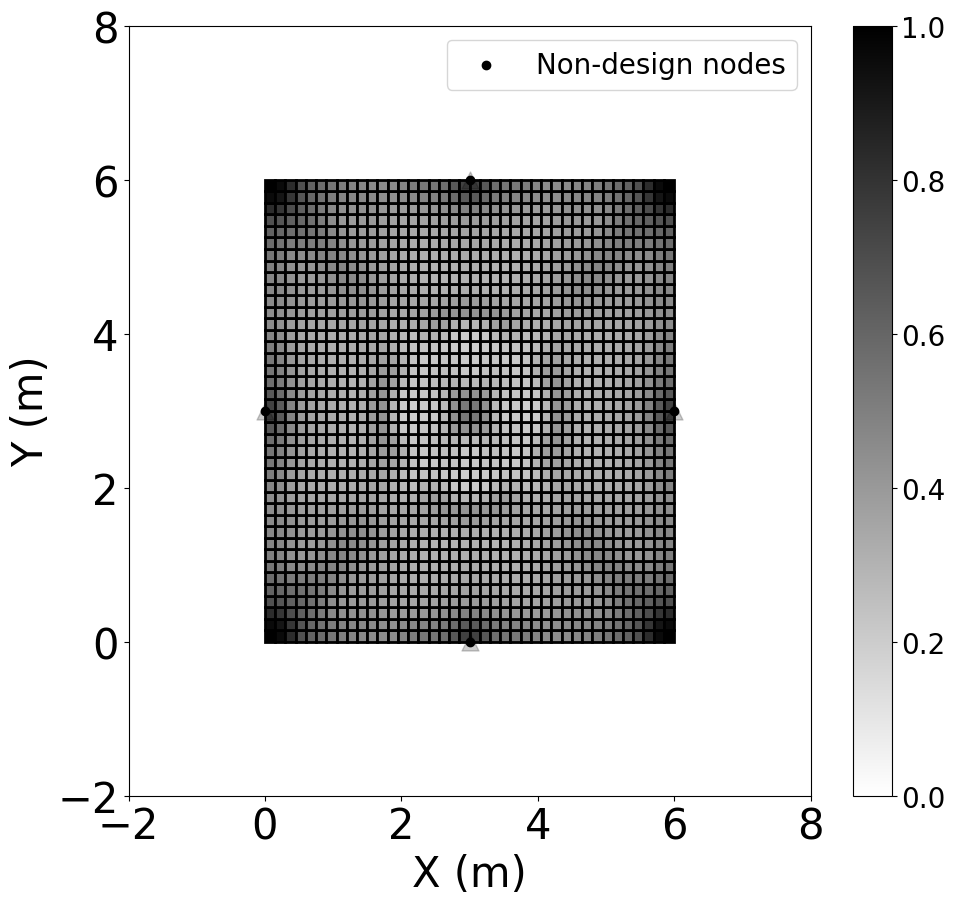

21th iteration, C = 169.01186379033803 
22th iteration, C = 69.2896288384477 
23th iteration, C = 20.912841551478216 
24th iteration, C = 15.435112612432853 
25th iteration, C = 15.748247243703302 
797.3404054736509


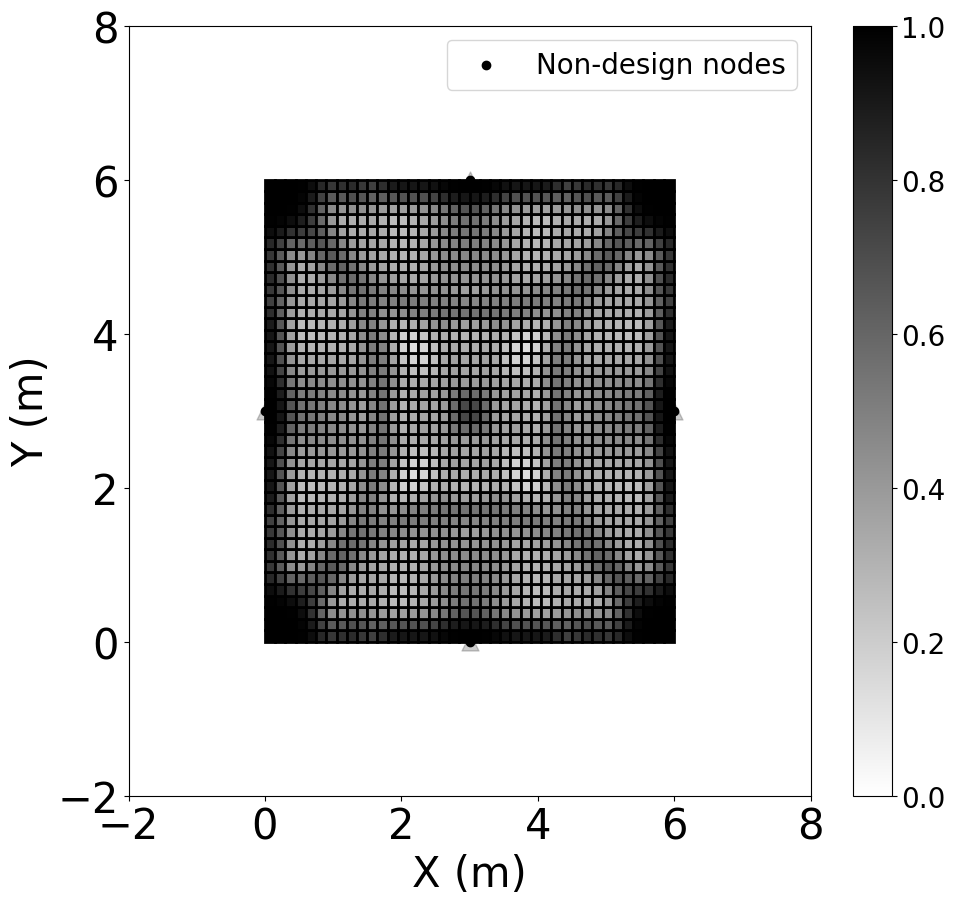

26th iteration, C = 12.50962306195691 
27th iteration, C = 10.848994163222875 
28th iteration, C = 10.020927492835385 
29th iteration, C = 6.846302269461097 
30th iteration, C = 3.942352756727743 
791.371807172956


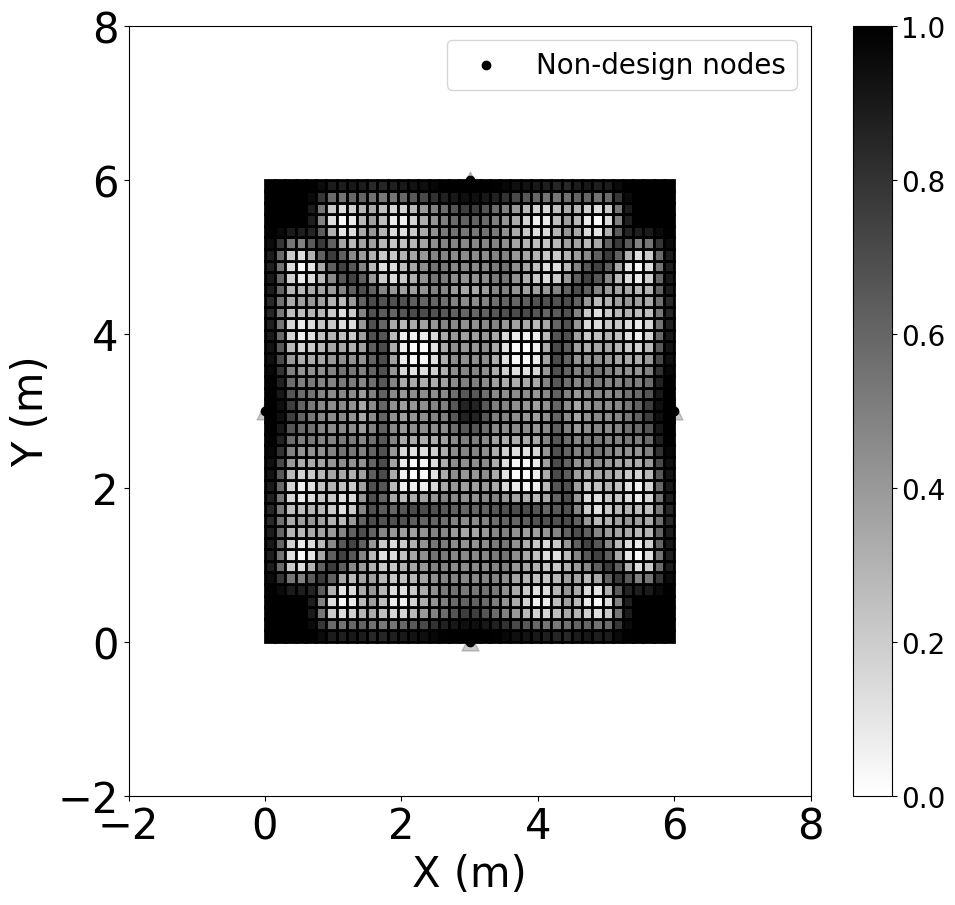

31th iteration, C = 14.599016921921638 
32th iteration, C = 3.49582097523793 
33th iteration, C = 3.3656008891672355 
34th iteration, C = 3.285213370793164 
35th iteration, C = 2.8856581467969953 
797.5908708403376


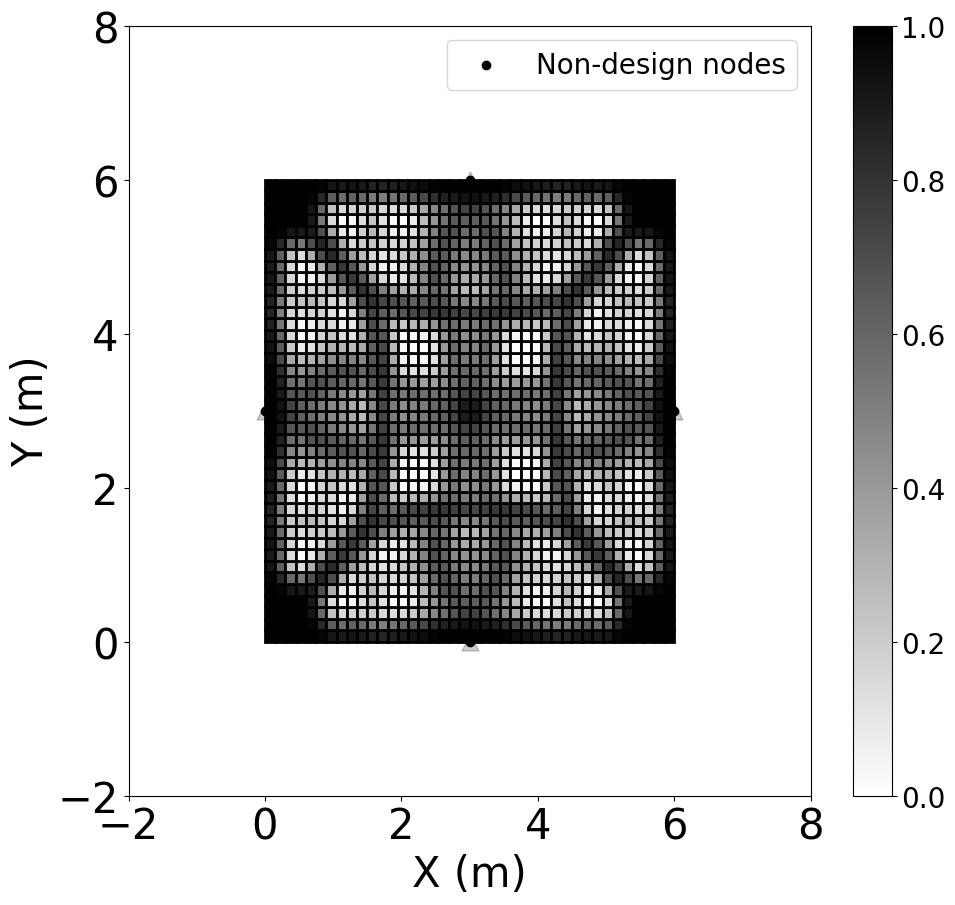

36th iteration, C = 11.326235261250941 
37th iteration, C = 4.819096585386352 
38th iteration, C = 2.8070702959870464 
39th iteration, C = 2.7479898978236537 
40th iteration, C = 2.7140121527843197 
799.9860501040577


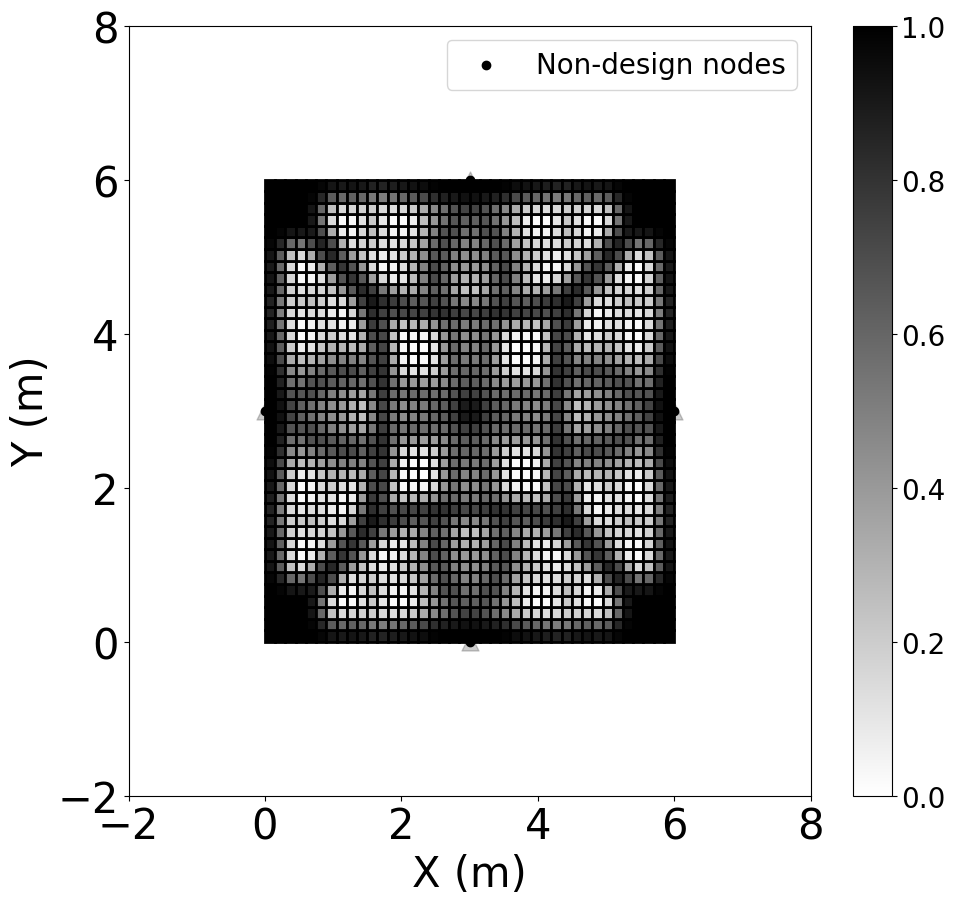

41th iteration, C = 2.504913841768711 
42th iteration, C = 6.825792177336346 
43th iteration, C = 2.700575352894363 
44th iteration, C = 2.4526053497744087 
45th iteration, C = 2.4140070659813397 
799.9535112012654


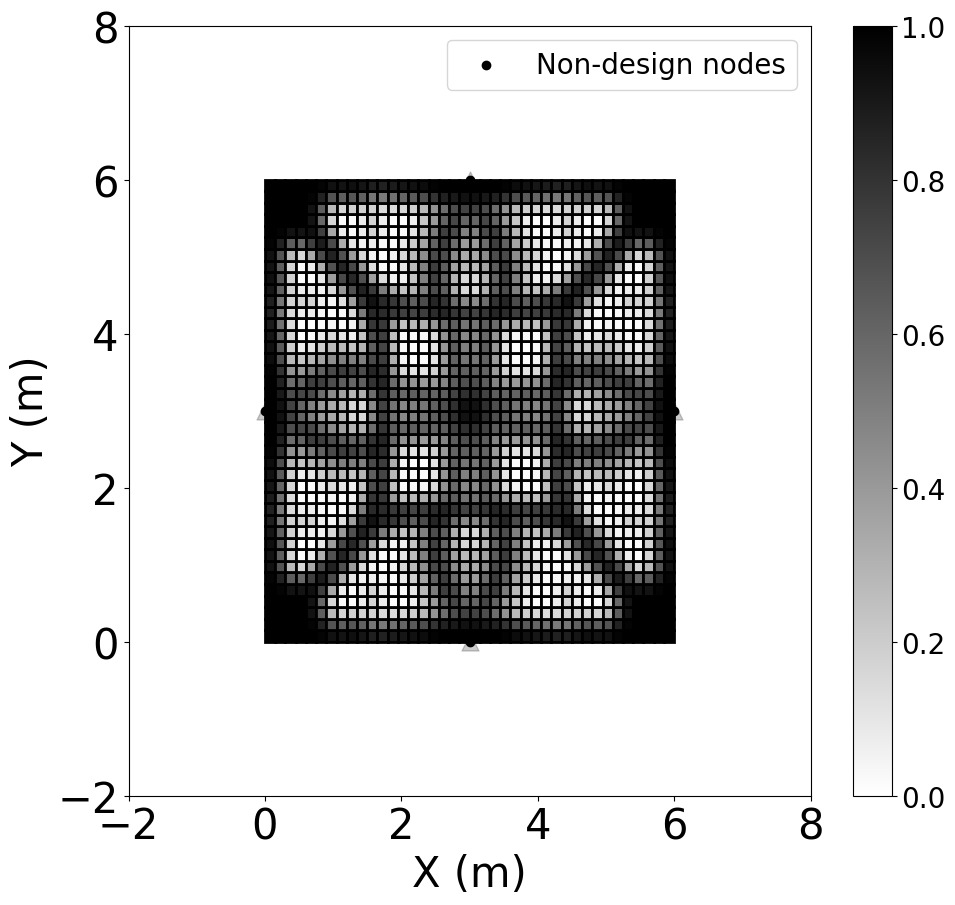

46th iteration, C = 2.9044140446610607 
47th iteration, C = 2.3654204116380826 
48th iteration, C = 2.3637995943441217 
49th iteration, C = 2.307456664975359 
50th iteration, C = 2.2878549155685985 
799.9957902178209


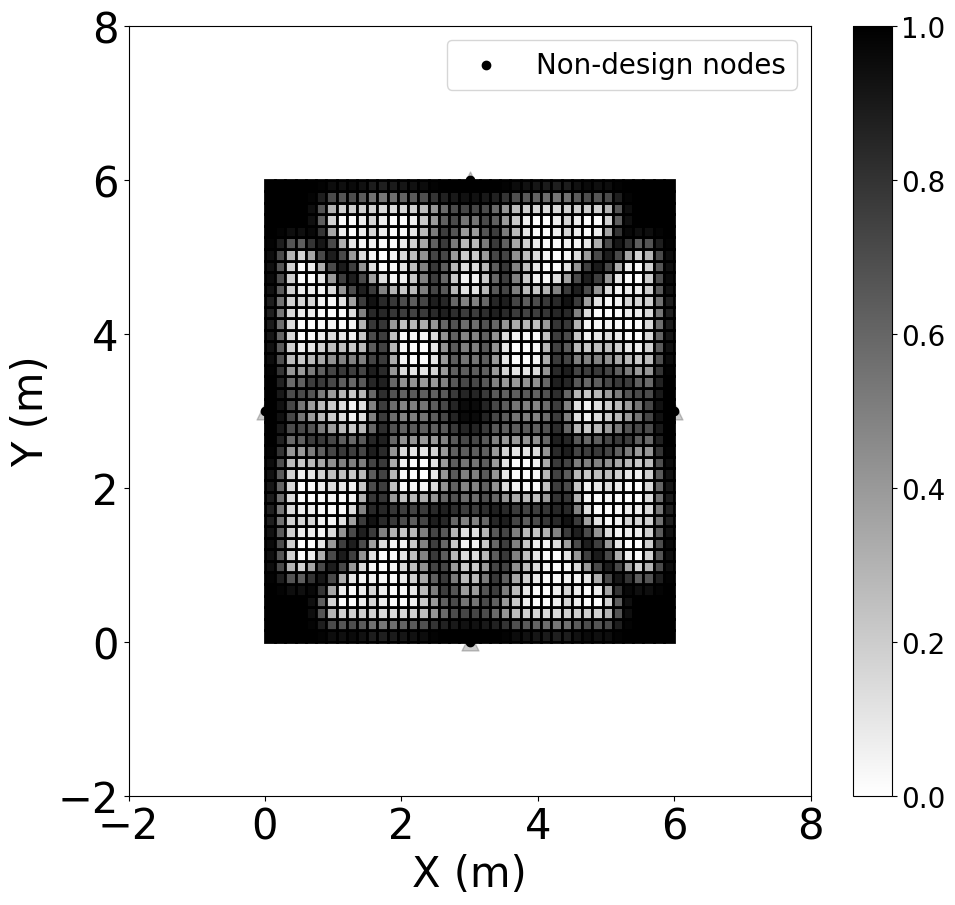

51th iteration, C = 2.1930428027272364 
52th iteration, C = 2.040597663817957 
53th iteration, C = 5.928887303399564 
54th iteration, C = 2.1921933018481563 
55th iteration, C = 1.9628683830737923 
799.9721058927687


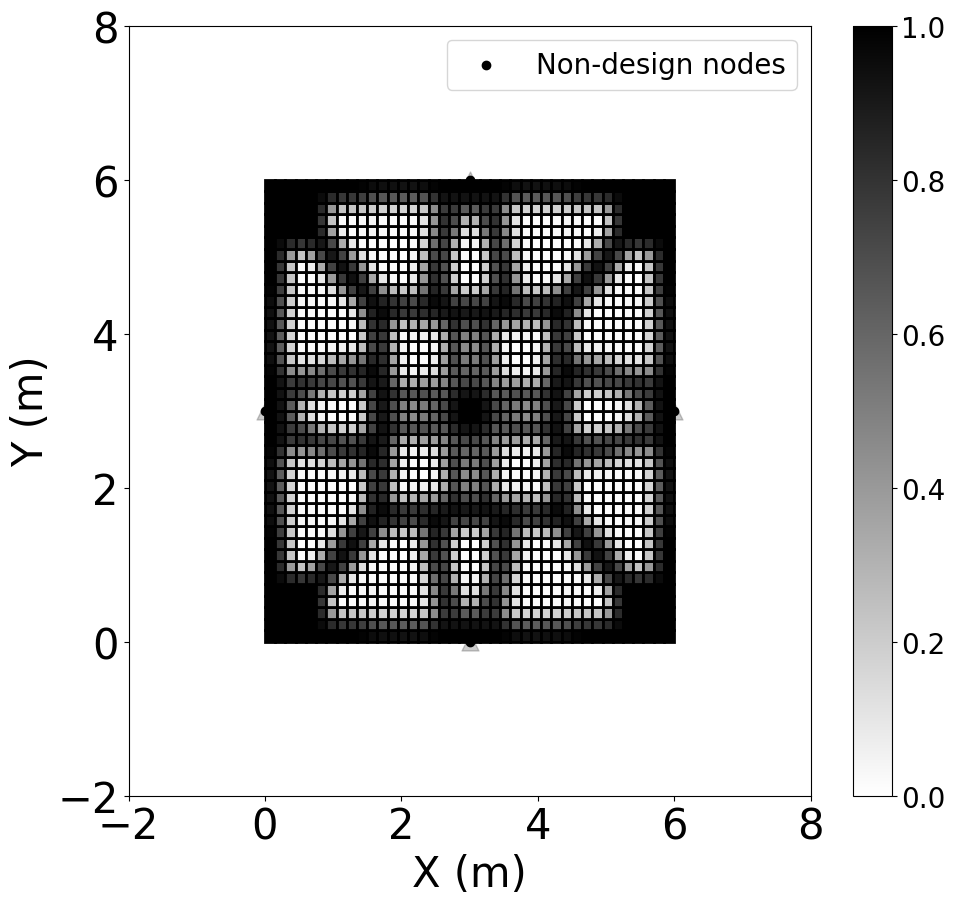

56th iteration, C = 2.019365242205474 
57th iteration, C = 1.927620303784936 
58th iteration, C = 3.3668409434064333 
59th iteration, C = 1.9311916198015489 
60th iteration, C = 1.9161860797177108 
799.9957137952215


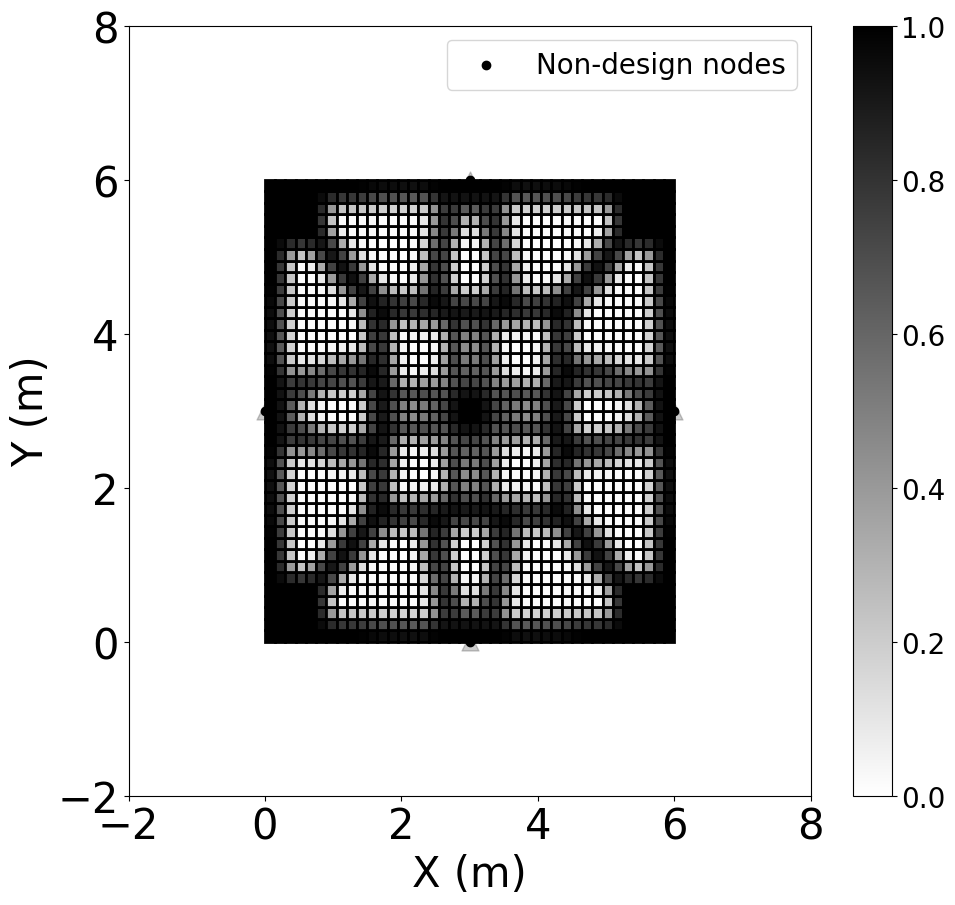

61th iteration, C = 1.891870060495868 
62th iteration, C = 2.40136858736613 
63th iteration, C = 1.8917189940225672 
64th iteration, C = 1.9733134754330806 
65th iteration, C = 1.8786012460671875 
799.9972315894822


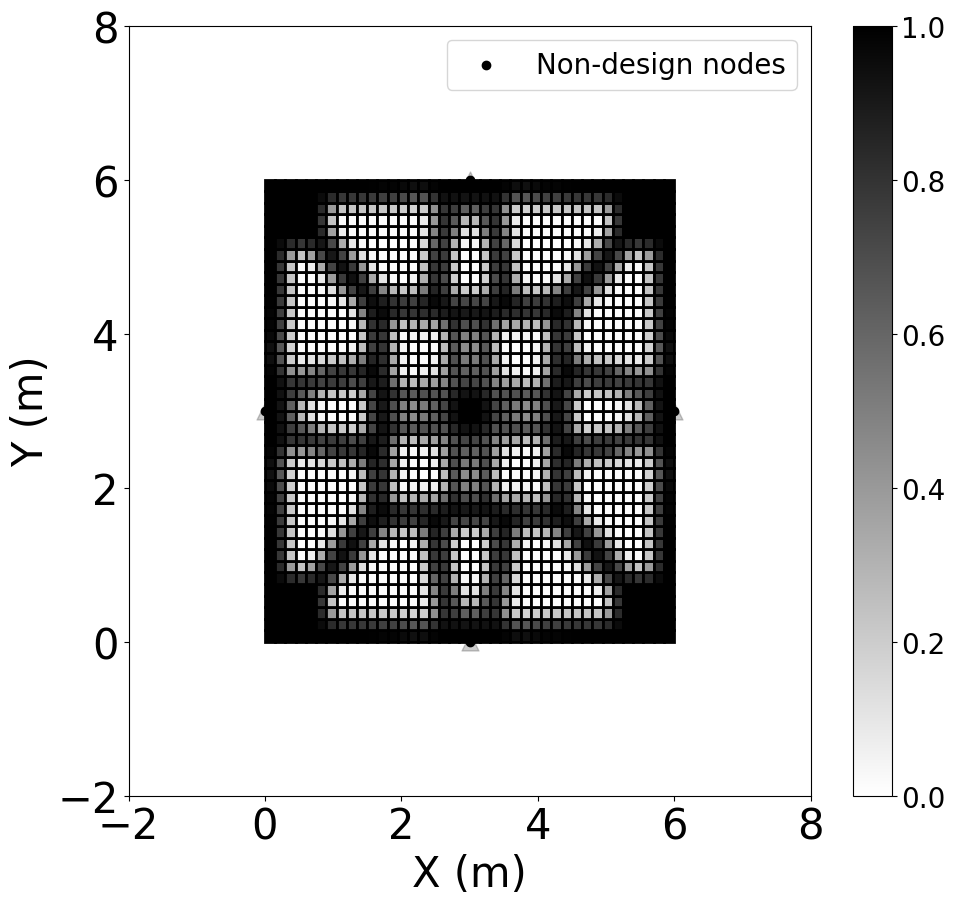

66th iteration, C = 1.877746223795434 
67th iteration, C = 1.9268428871150596 
68th iteration, C = 1.861245757999377 
69th iteration, C = 1.85845949566506 
70th iteration, C = 1.848743995981507 
799.924994335216


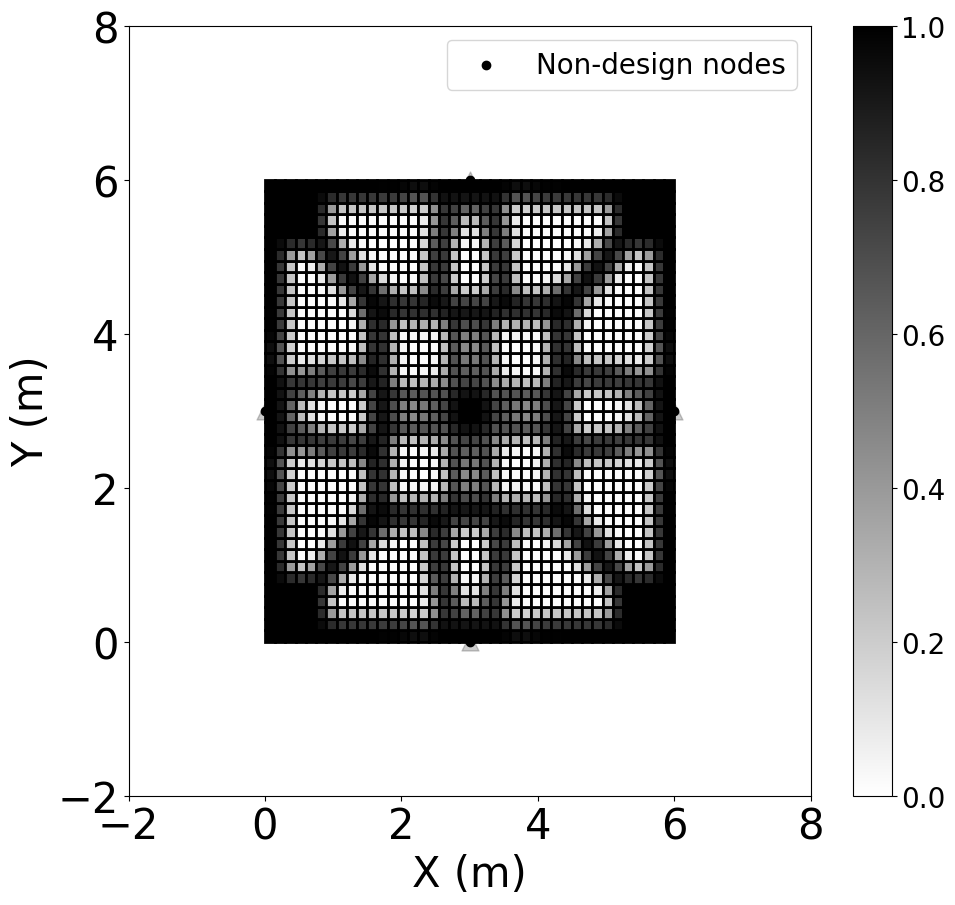

71th iteration, C = 5.32650407270523 
72th iteration, C = 1.9134179242827916 
73th iteration, C = 1.8414307536456984 
74th iteration, C = 1.8631380912697728 
75th iteration, C = 1.834227384988269 
799.9634491385178


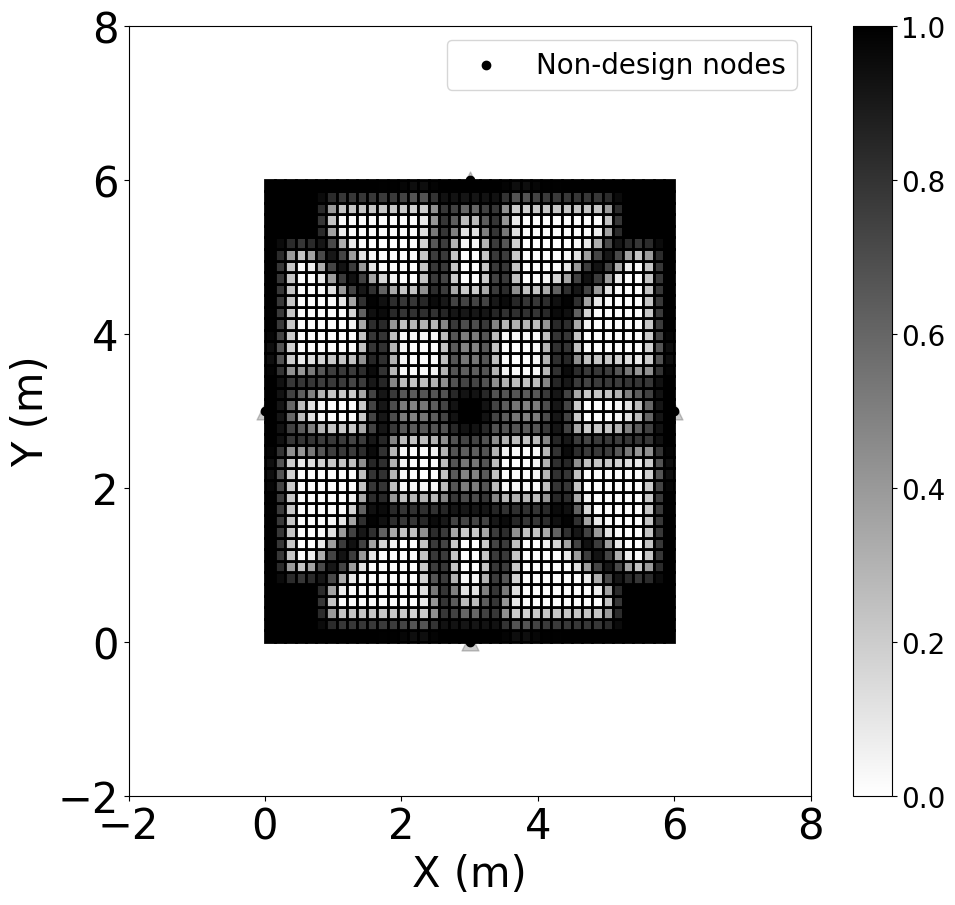

76th iteration, C = 1.8425327426537423 
77th iteration, C = 1.8281926944020304 
78th iteration, C = 1.8123306807863118 
79th iteration, C = 6.04545763778143 
80th iteration, C = 2.084687528647463 
799.8805536578676


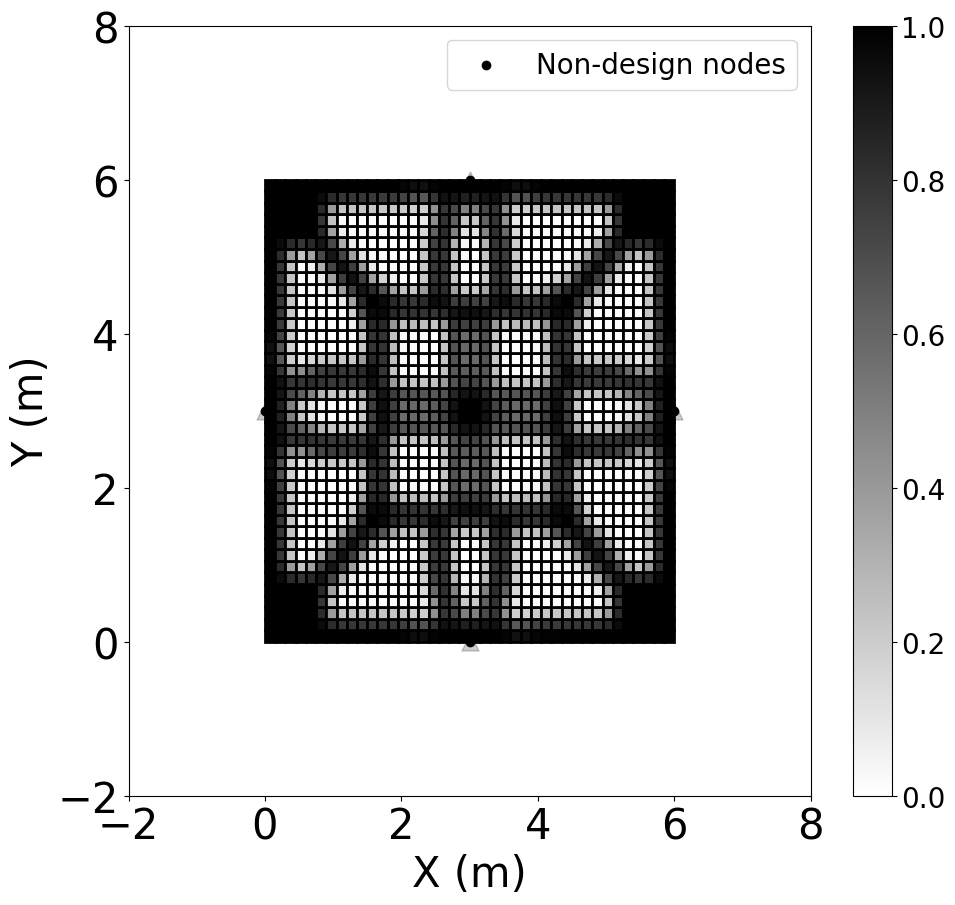

81th iteration, C = 1.805966476393996 
82th iteration, C = 1.8033639408022348 
83th iteration, C = 1.7921186329241714 
84th iteration, C = 1.9938878565220348 
85th iteration, C = 1.7846478796568506 
799.9989140439882


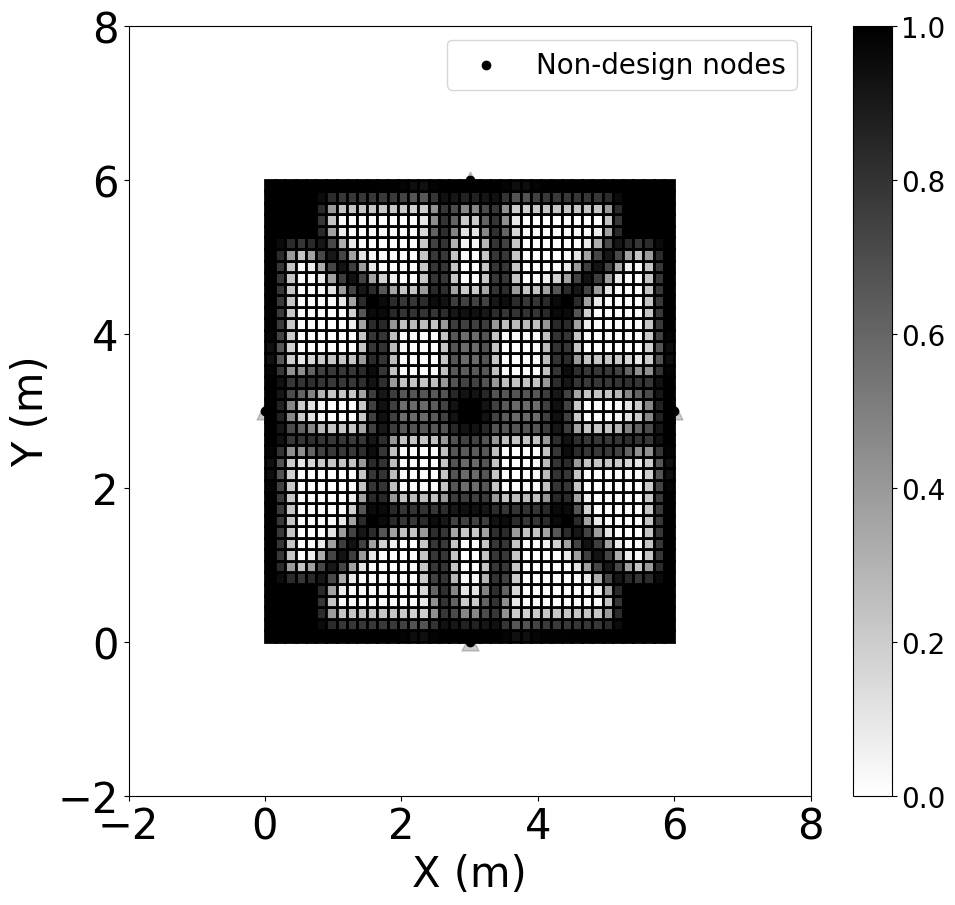

86th iteration, C = 1.782831301192717 
87th iteration, C = 1.7735747369097354 
88th iteration, C = 2.4334889713349805 
89th iteration, C = 1.7918998964601491 
90th iteration, C = 1.7710558056990813 
799.9954338980652


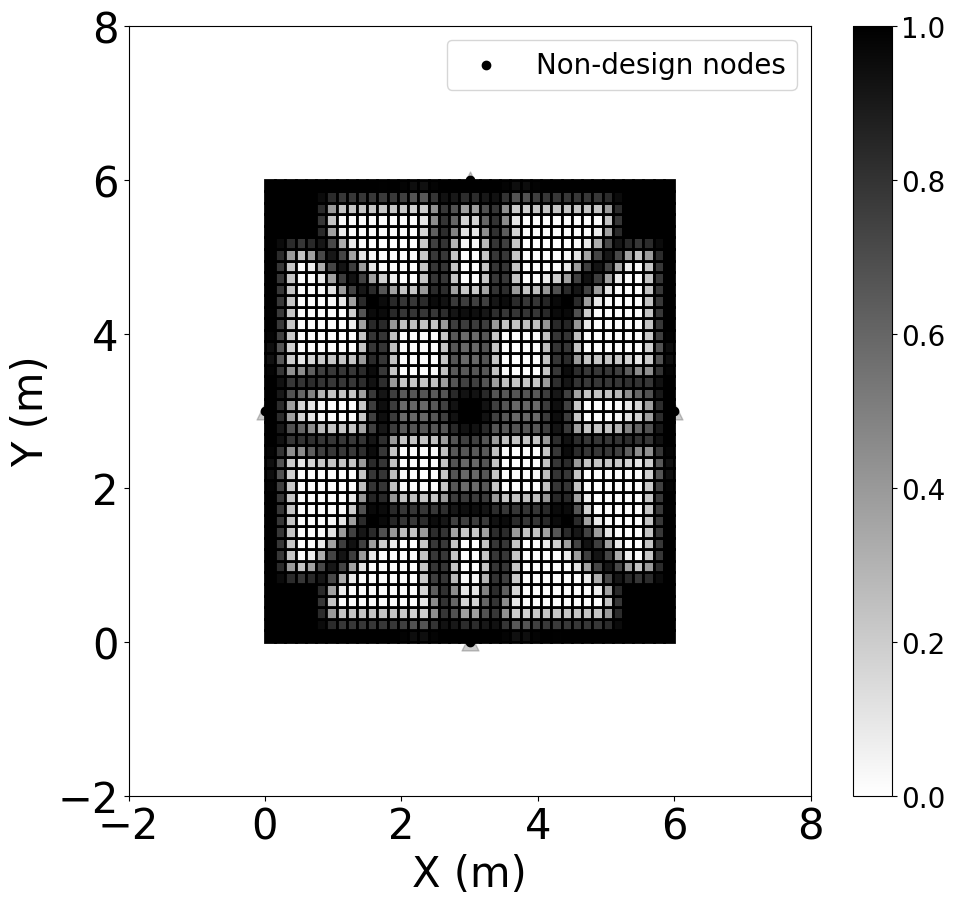

91th iteration, C = 1.7689714433824468 
92th iteration, C = 1.7913880503055408 
93th iteration, C = 1.76640323099348 
94th iteration, C = 1.769595948727406 
95th iteration, C = 1.7639498259586184 
799.9996730325886


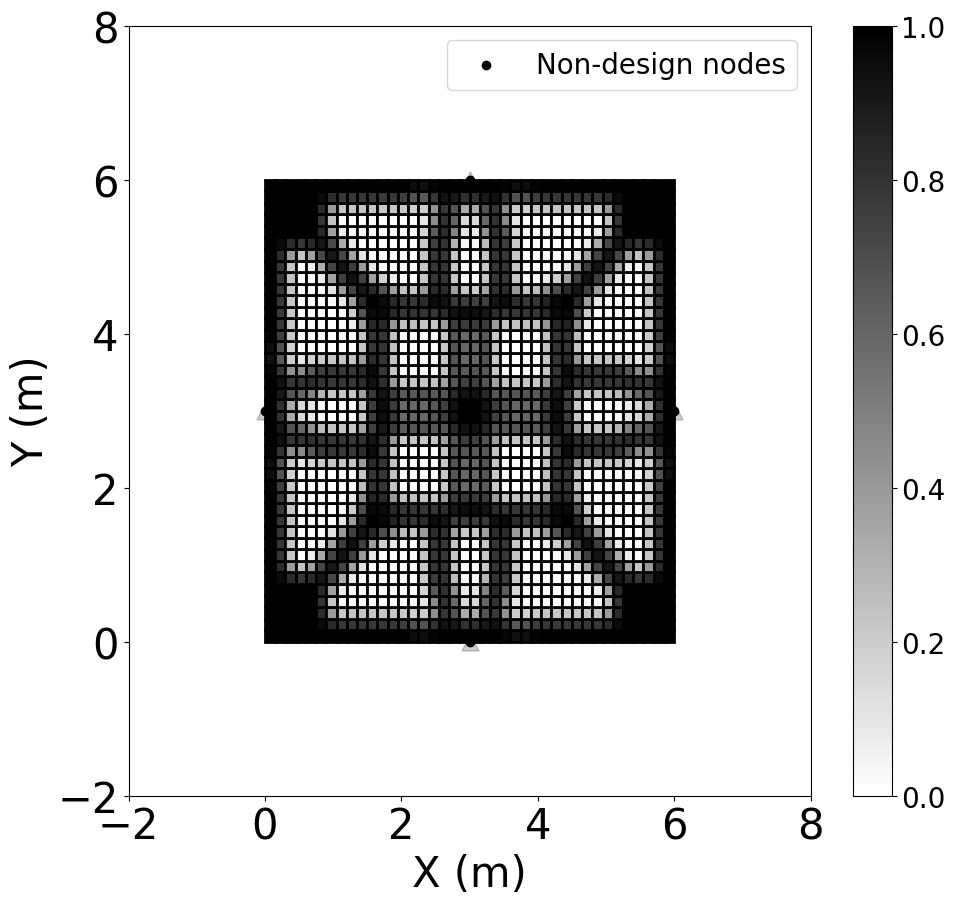

96th iteration, C = 1.755395858484129 
97th iteration, C = 4.905085642915982 
98th iteration, C = 2.077096726278486 
99th iteration, C = 1.753262131083817 
100th iteration, C = 1.7512355929323409 
799.9996382067043


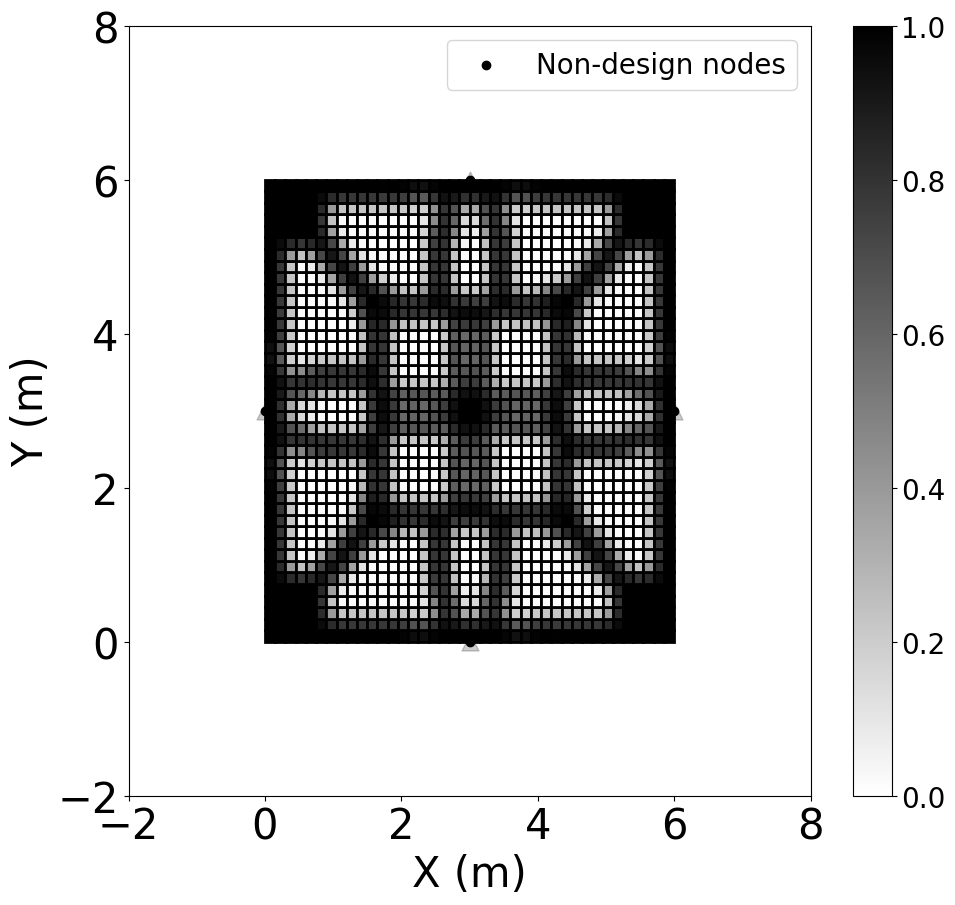

101th iteration, C = 1.743252386792447 
102th iteration, C = 3.3230068783781674 
103th iteration, C = 1.8228089949857846 
104th iteration, C = 1.740363955374807 
105th iteration, C = 1.7275176536154453 
799.9676123528827


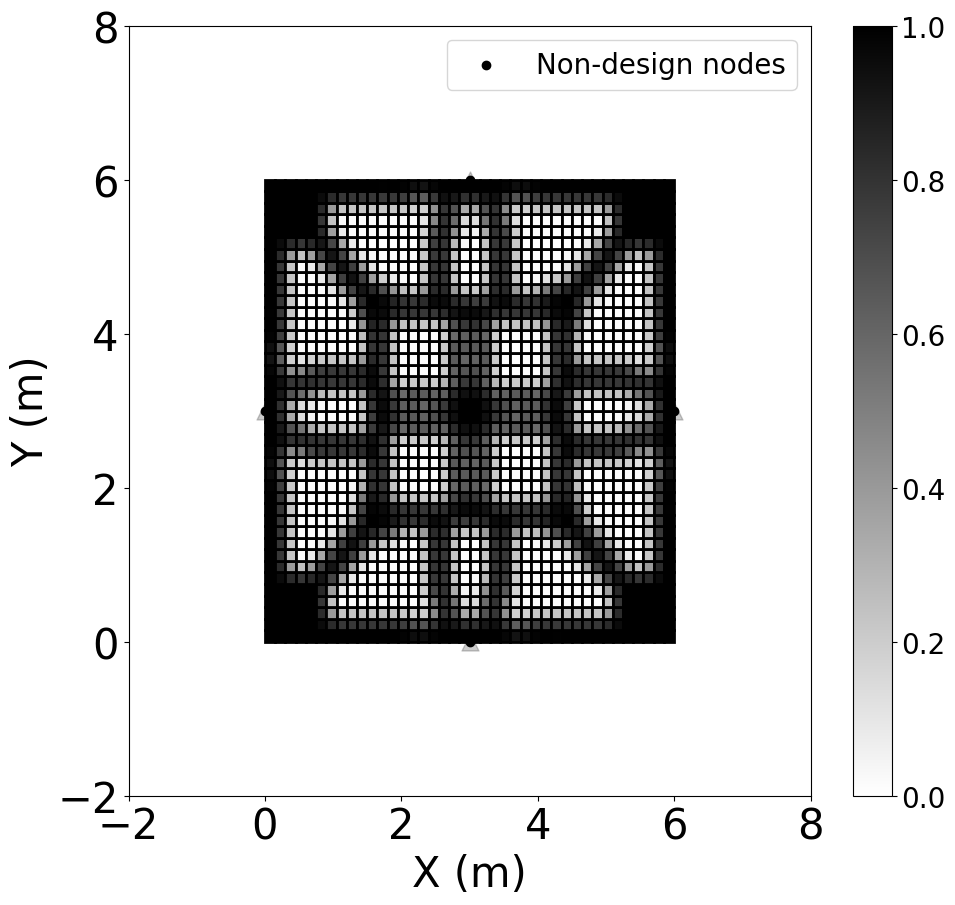

106th iteration, C = 3.236502955994549 
107th iteration, C = 1.8102216067021222 
108th iteration, C = 1.7217023322606215 
109th iteration, C = 1.7144152096329885 
110th iteration, C = 2.0460900085058933 
799.9004295418629


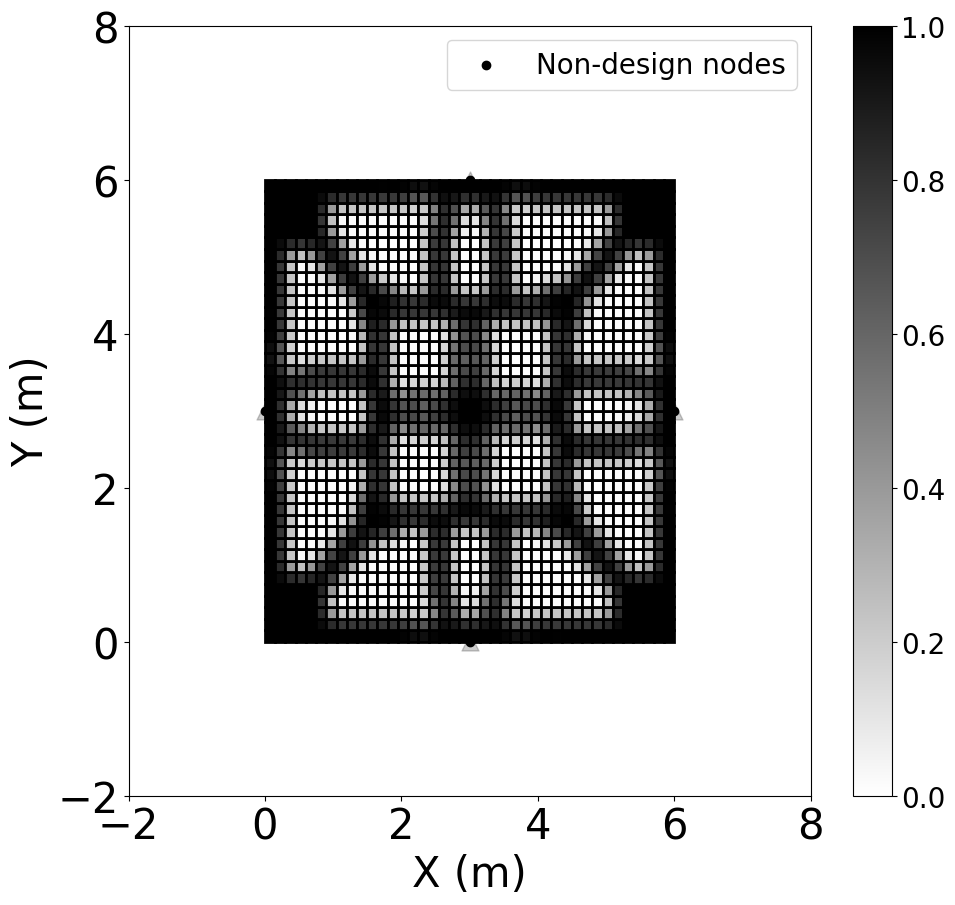

111th iteration, C = 1.7026240998925435 
112th iteration, C = 1.7009095082212817 
113th iteration, C = 1.6929375368791433 
114th iteration, C = 2.345920201439026 
115th iteration, C = 1.71264840229848 
799.8739094751379


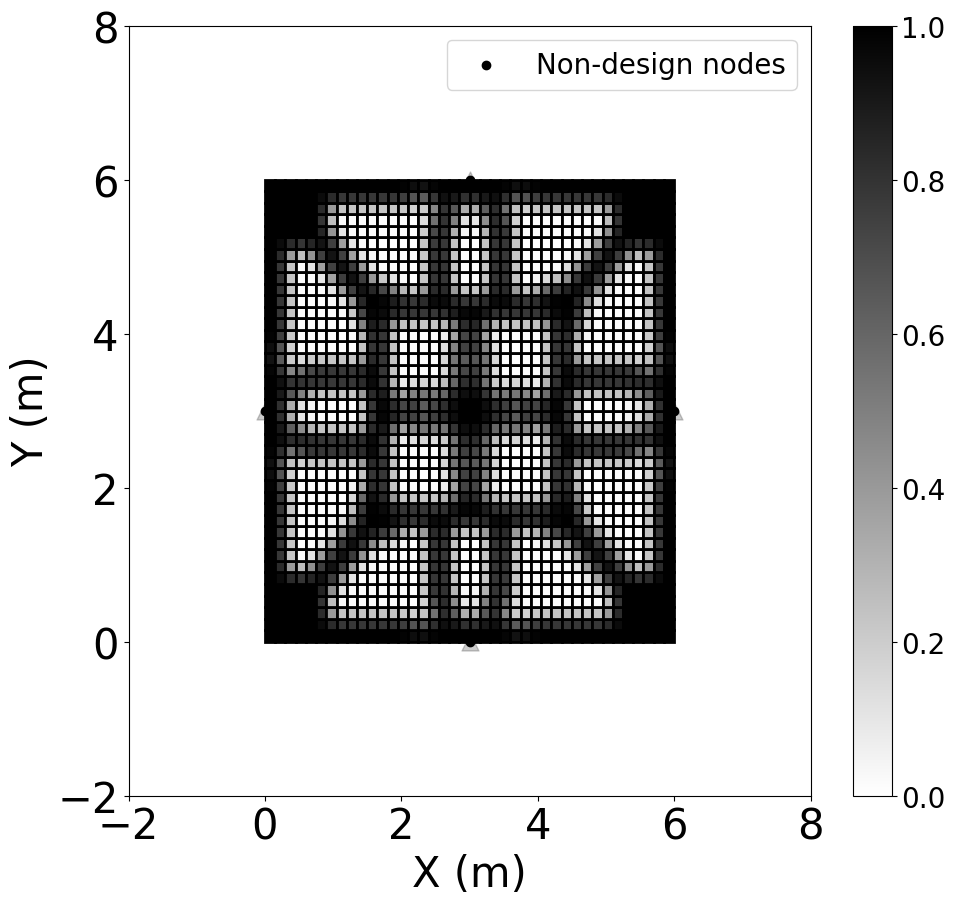

116th iteration, C = 1.6900404894044543 
117th iteration, C = 1.6874594505367664 
118th iteration, C = 1.676127909167822 
119th iteration, C = 3.5207682578043684 
120th iteration, C = 1.8674315540816273 
799.7640005581338


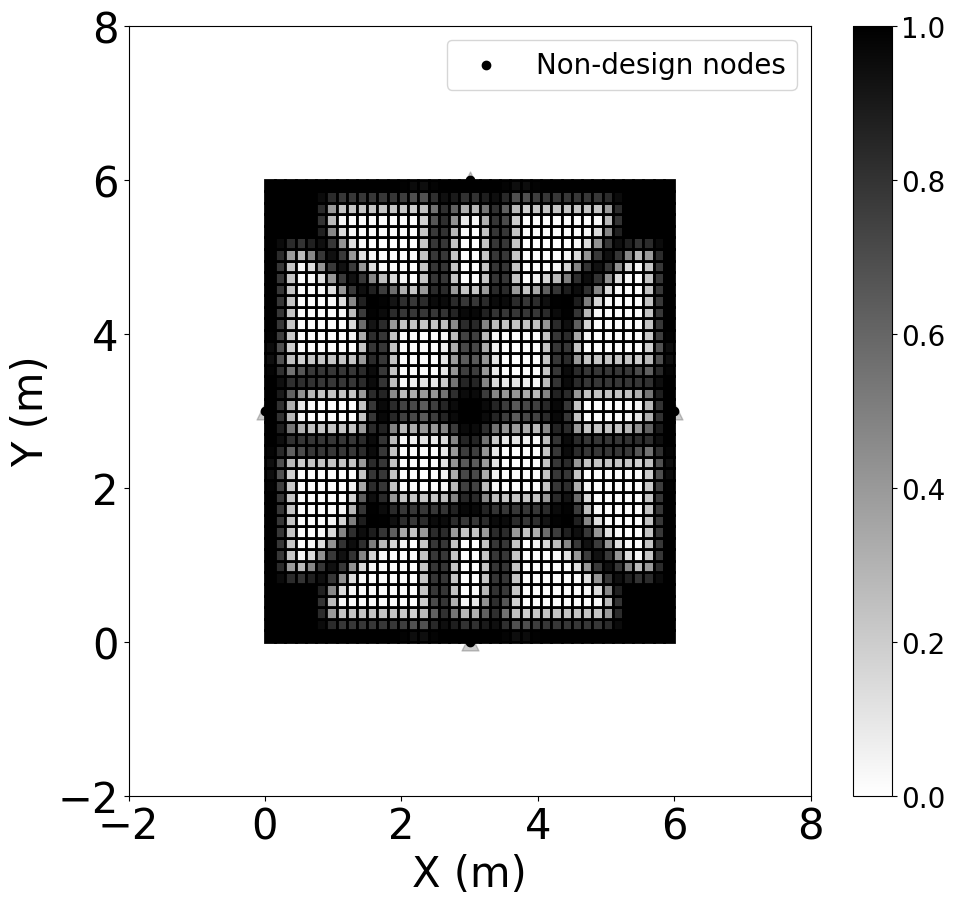

121th iteration, C = 1.6729123100137635 
122th iteration, C = 1.671235588673674 
123th iteration, C = 1.6640034636624008 
124th iteration, C = 4.7753979022488355 
125th iteration, C = 1.8879594813903662 
799.7909361650659


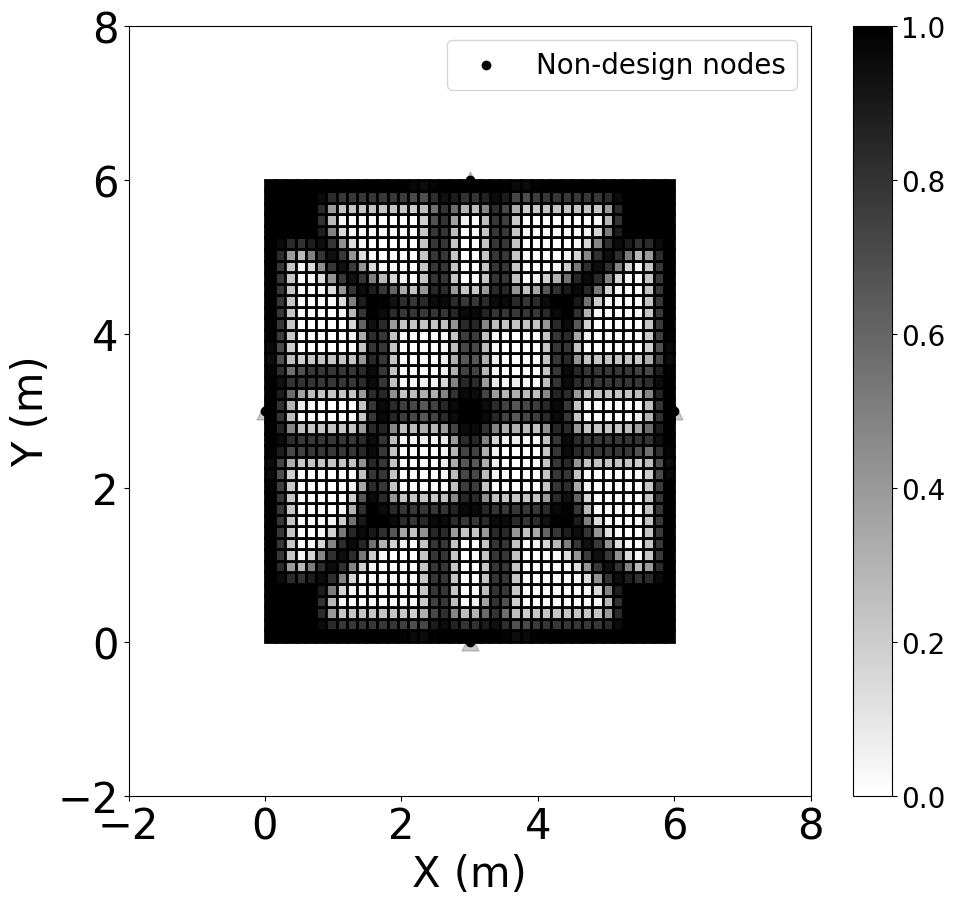

126th iteration, C = 1.6605185151151762 
127th iteration, C = 1.6577356125185496 
128th iteration, C = 1.6505791263243415 
129th iteration, C = 2.260074634156803 
130th iteration, C = 1.665020989938651 
799.9357200486542


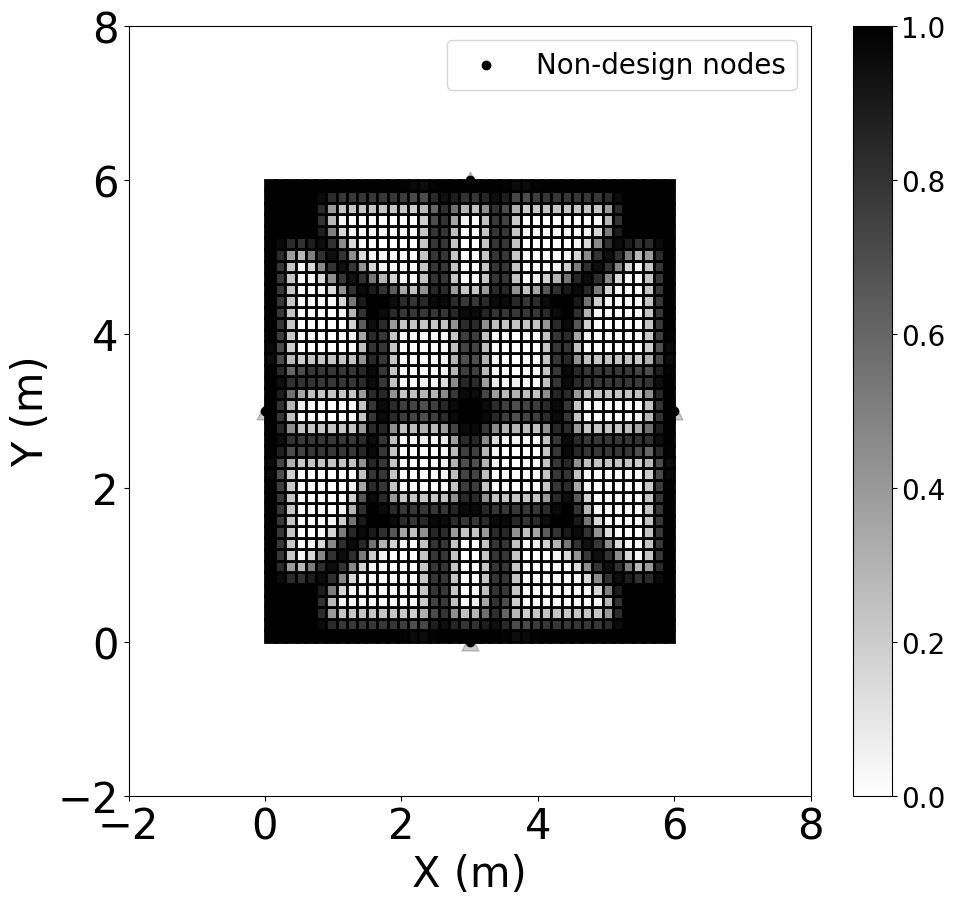

131th iteration, C = 1.6484604975416763 
132th iteration, C = 1.6428778095877548 
133th iteration, C = 1.8819119853614372 
134th iteration, C = 1.6388894181269136 
135th iteration, C = 1.6374058833404885 
799.9992215242507


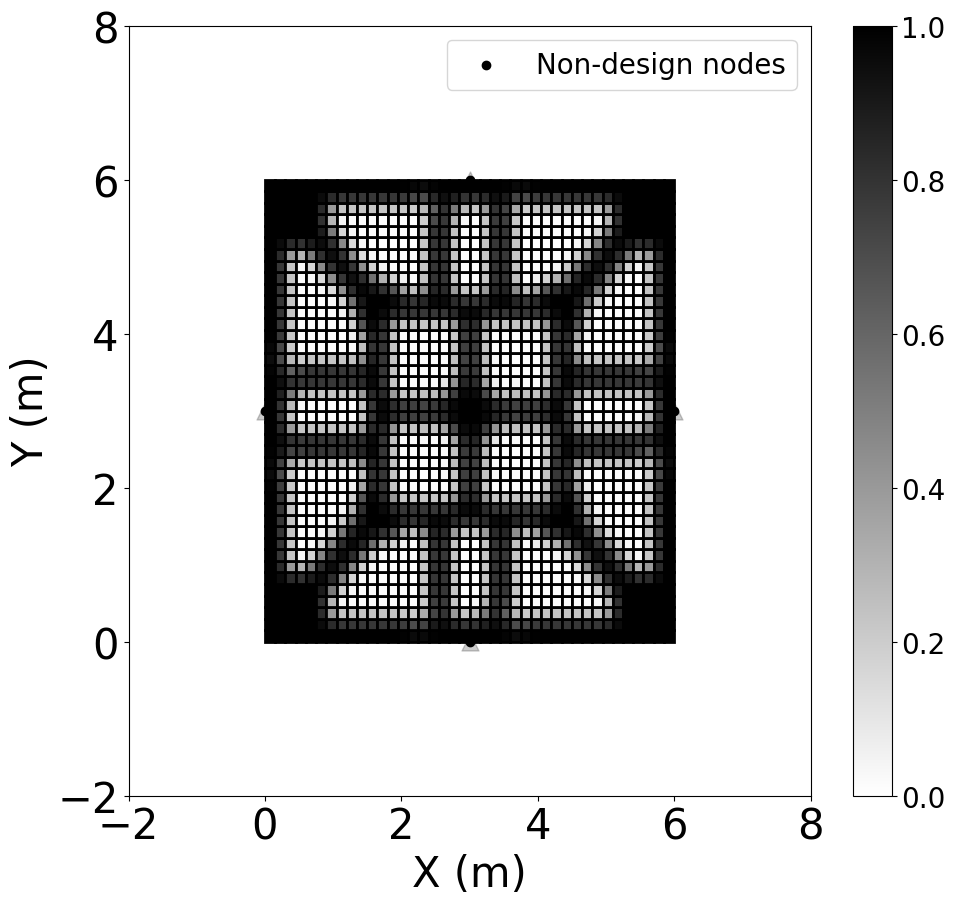

136th iteration, C = 1.634266543415523 
137th iteration, C = 1.6485965911604772 
138th iteration, C = 1.6326287857230564 
139th iteration, C = 1.630550591689621 
140th iteration, C = 2.6911964978602896 
799.8575621551647


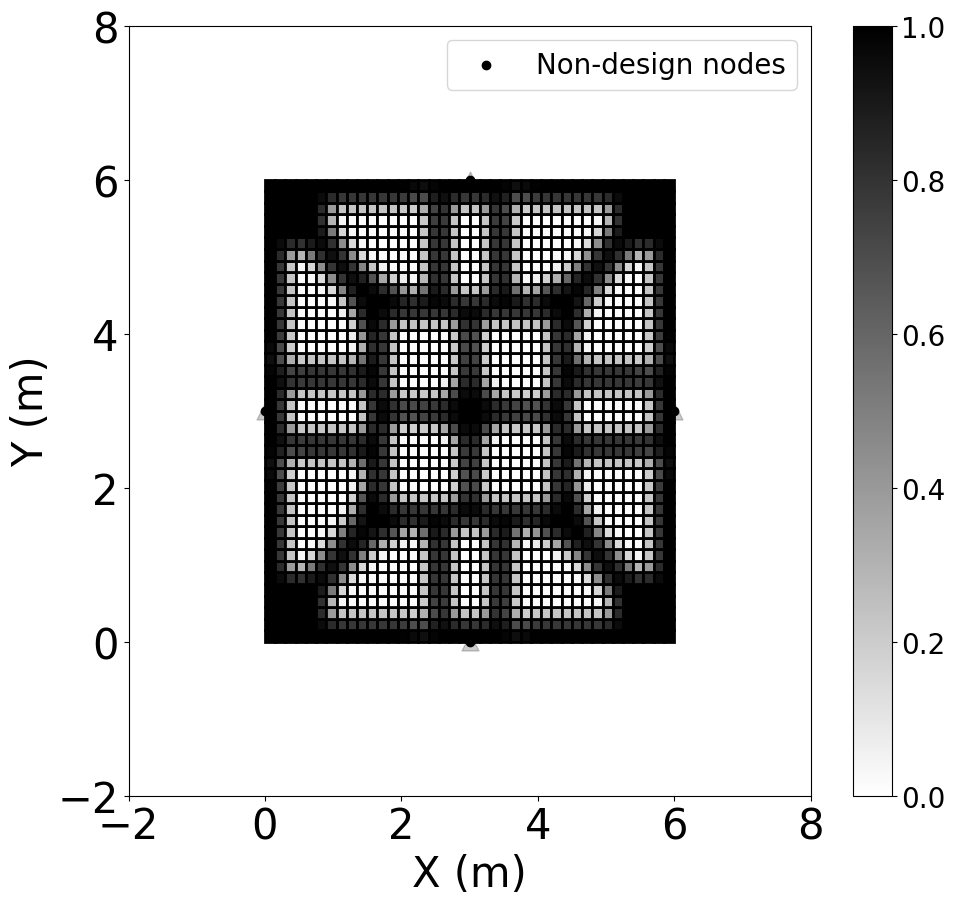

141th iteration, C = 1.641466561434864 
142th iteration, C = 1.6294525659158288 
143th iteration, C = 1.6267566334302572 
144th iteration, C = 2.868519743330365 
145th iteration, C = 1.6701919864328358 
799.9878626394261


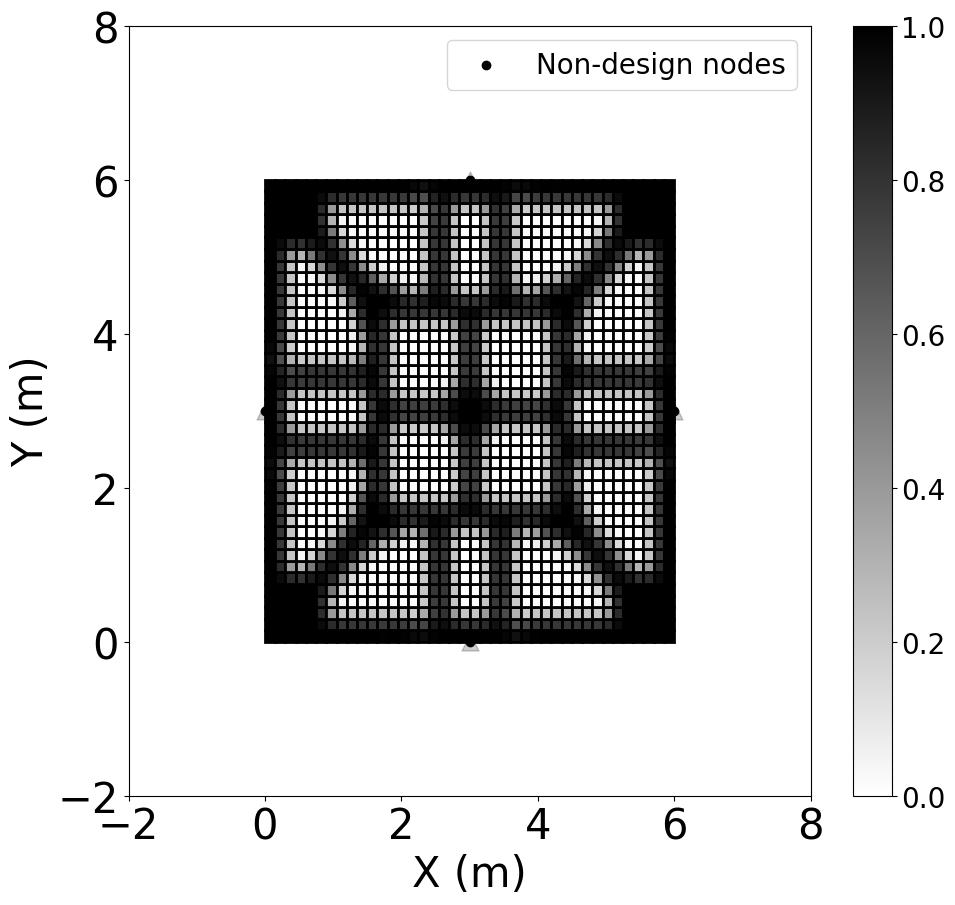

146th iteration, C = 1.6254475426970856 
147th iteration, C = 1.6230337877709256 
148th iteration, C = 2.067944458173479 
149th iteration, C = 1.6389420811897986 
150th iteration, C = 1.6224562308449066 
799.999611102188


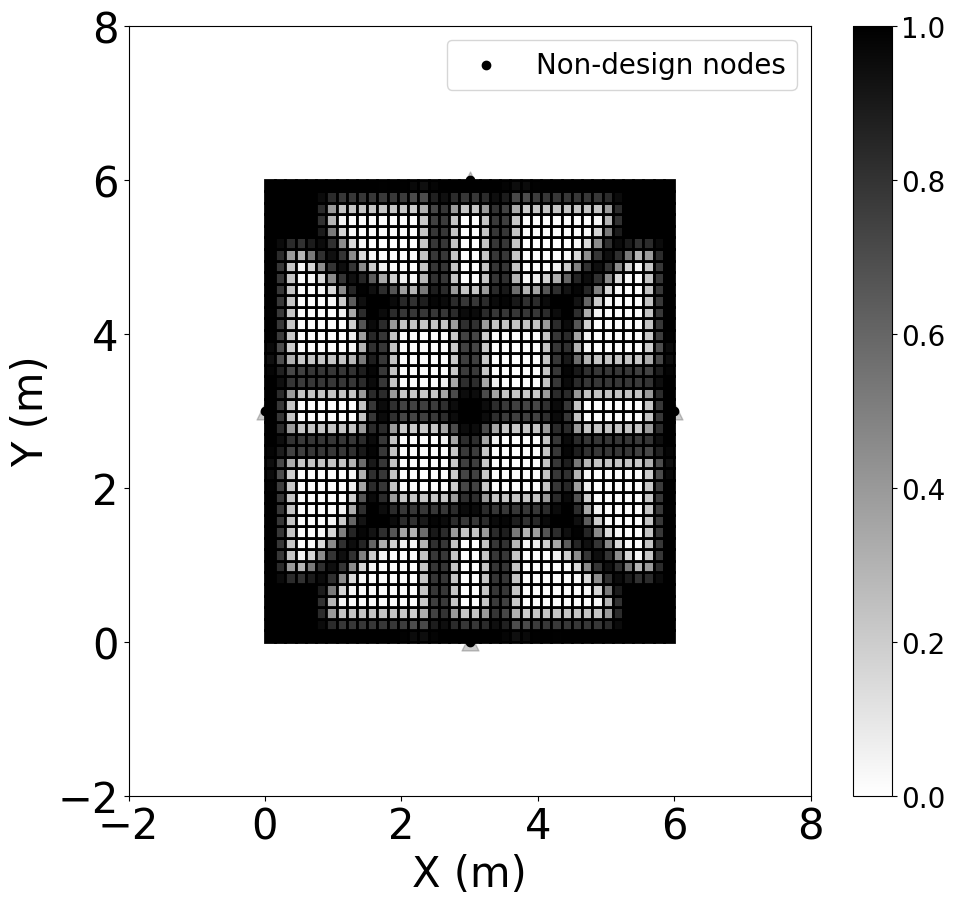

151th iteration, C = 1.6216995799255787 
152th iteration, C = 1.6707522255914162 
153th iteration, C = 1.6198470228043278 
154th iteration, C = 1.6194181571310362 
155th iteration, C = 1.6191521898970584 
799.9977565426236


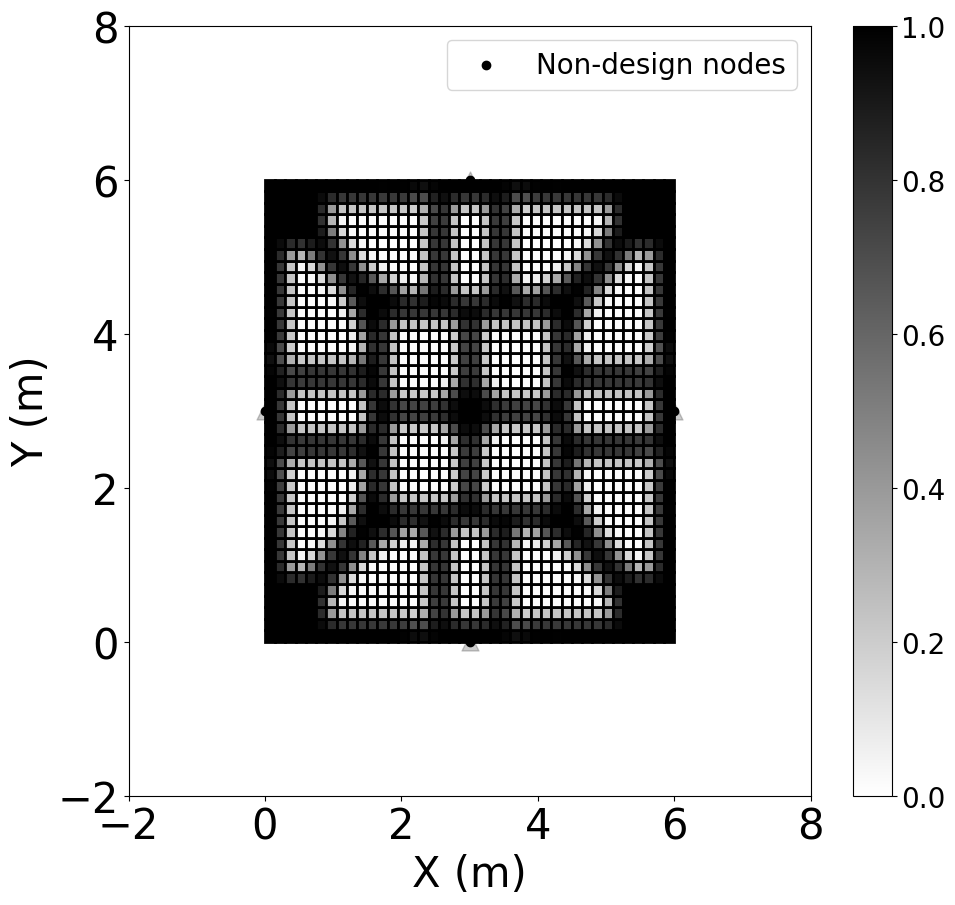

156th iteration, C = 1.6183791342801264 
157th iteration, C = 1.6180178199118882 
158th iteration, C = 1.6172848397014337 
159th iteration, C = 1.6385535037816696 
160th iteration, C = 1.6172369483775142 
799.9966486403036


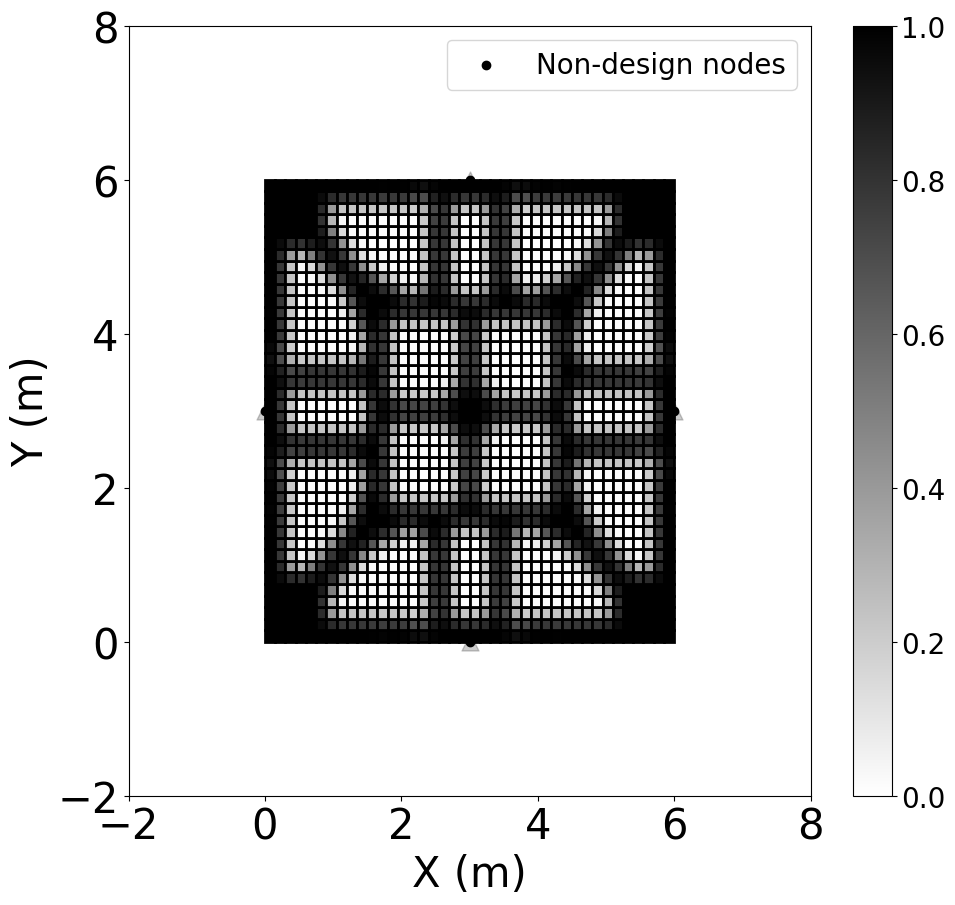

161th iteration, C = 1.6208141908055271 
162th iteration, C = 1.6162311716275333 
163th iteration, C = 1.6152744342851395 
164th iteration, C = 1.9616506731461296 
165th iteration, C = 1.6282916211184308 
799.9940303872735


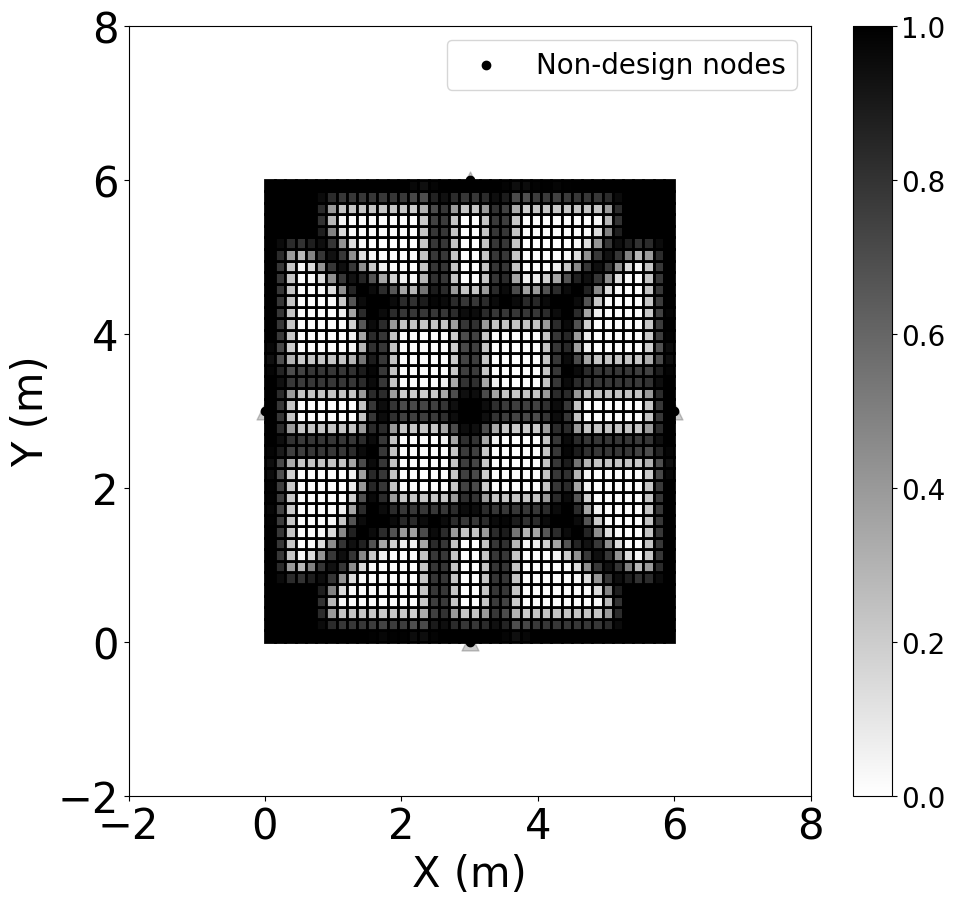

166th iteration, C = 1.6146673866124135 
167th iteration, C = 1.6137720771000377 
168th iteration, C = 1.6483211650583238 
169th iteration, C = 1.6125137387638637 
170th iteration, C = 1.6120795430605852 
799.9999394767078


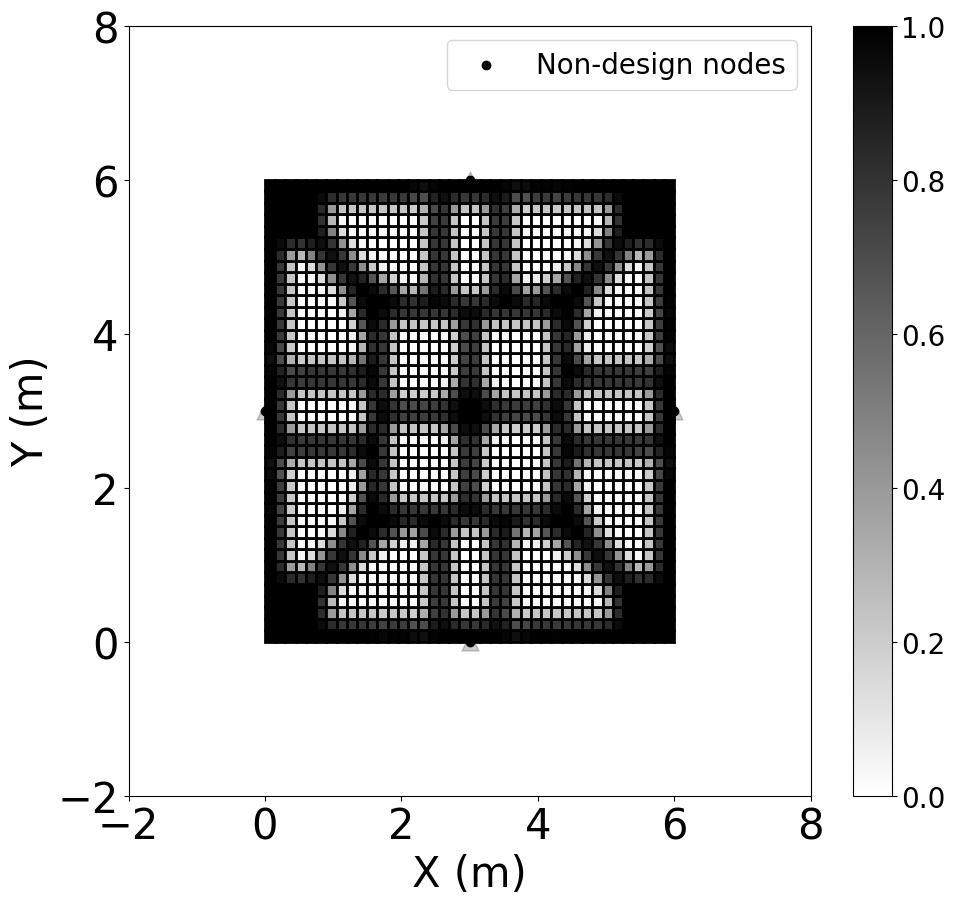

171th iteration, C = 1.6116042751056472 
172th iteration, C = 1.622896741260434 
173th iteration, C = 1.6109711107748146 
174th iteration, C = 1.6105197893576302 
175th iteration, C = 1.6123792877237662 
799.9982105750724


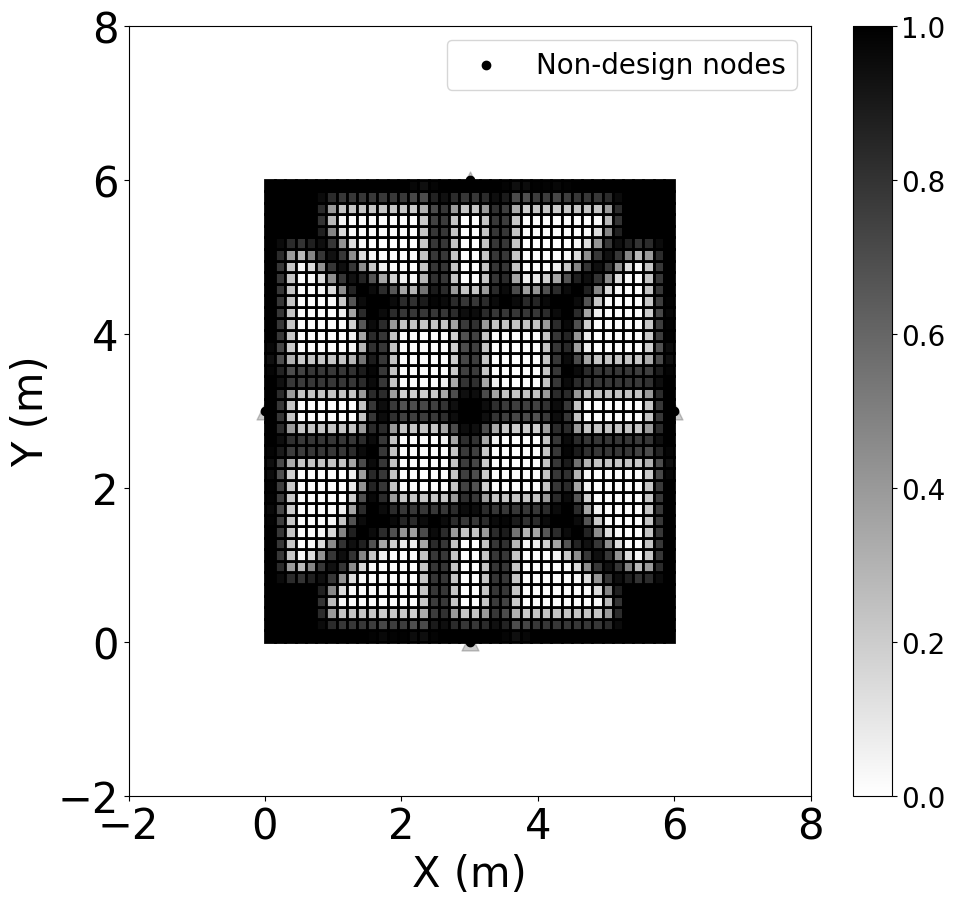

176th iteration, C = 1.6096851014507692 
177th iteration, C = 1.608001899106124 
178th iteration, C = 1.7339864513809766 
179th iteration, C = 1.6093452955247125 
180th iteration, C = 1.6075046509926825 
799.9996900045983


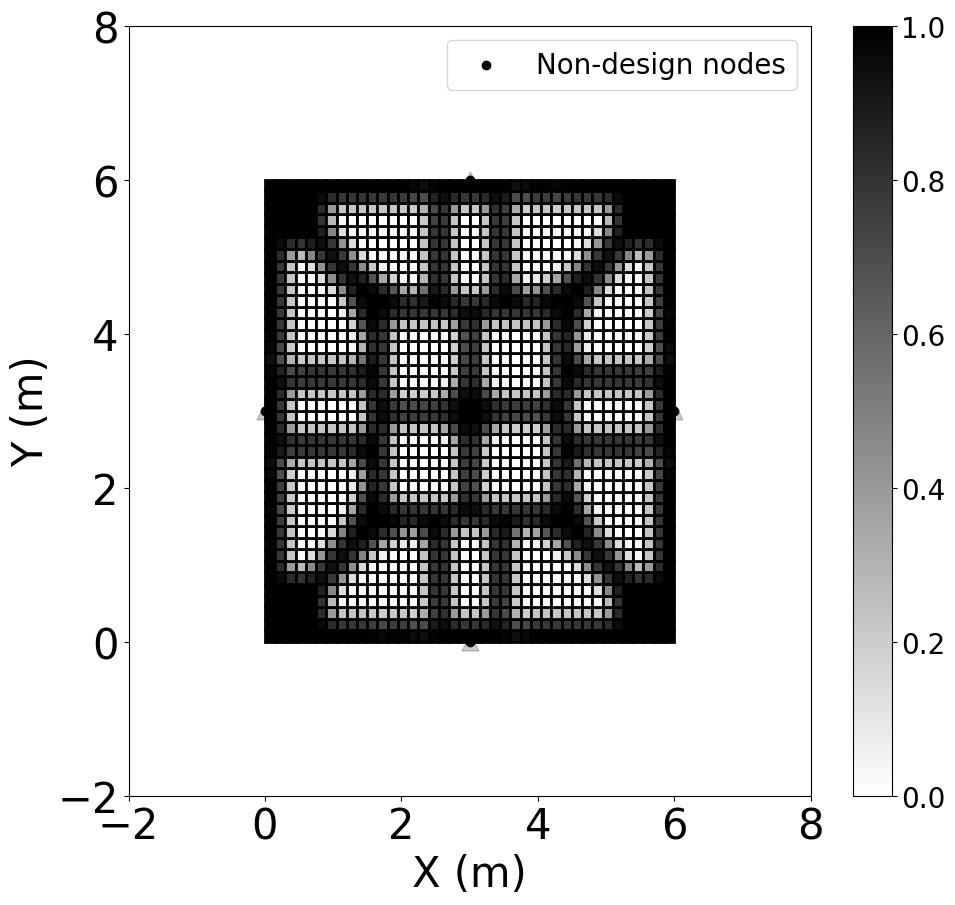

181th iteration, C = 1.6112964284003306 
182th iteration, C = 1.606749293819373 
183th iteration, C = 1.6114886645653512 
184th iteration, C = 1.606153834116135 
185th iteration, C = 1.6045524826347963 
799.9988364533258


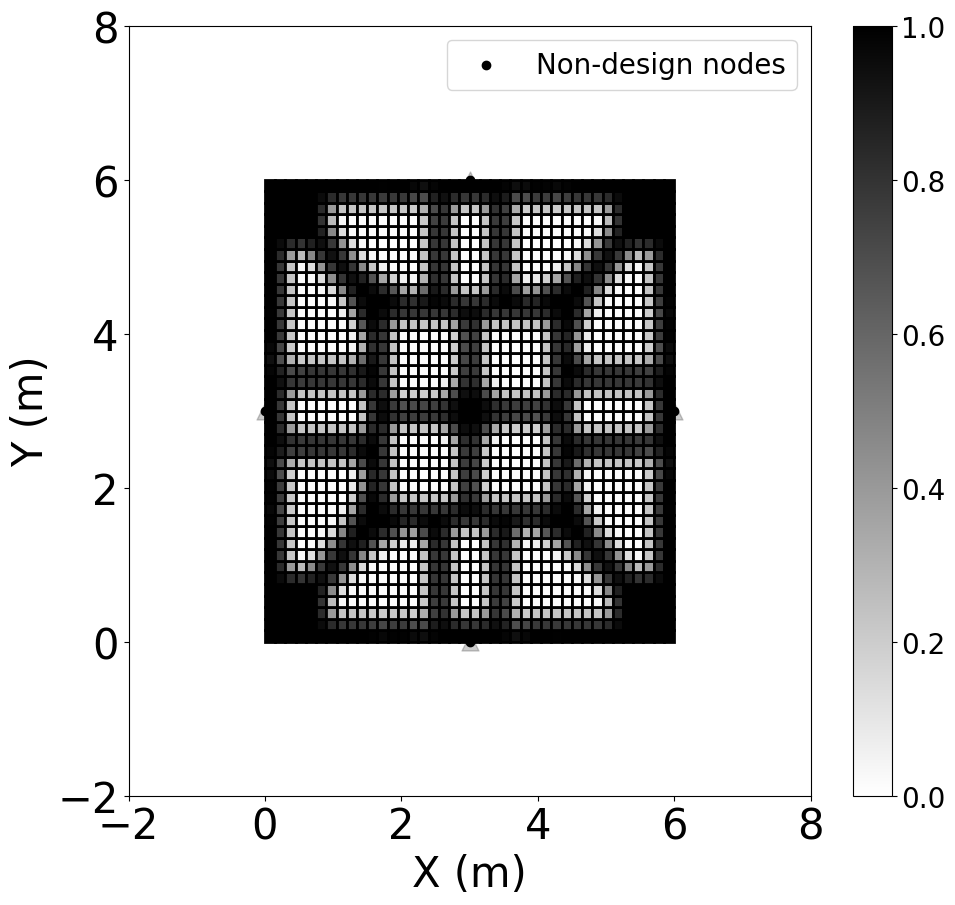

186th iteration, C = 2.1524560064793596 
187th iteration, C = 1.6337499292154685 
188th iteration, C = 1.604032432092983 
189th iteration, C = 1.6023311395455275 
190th iteration, C = 1.708153132524754 
799.9850697063479


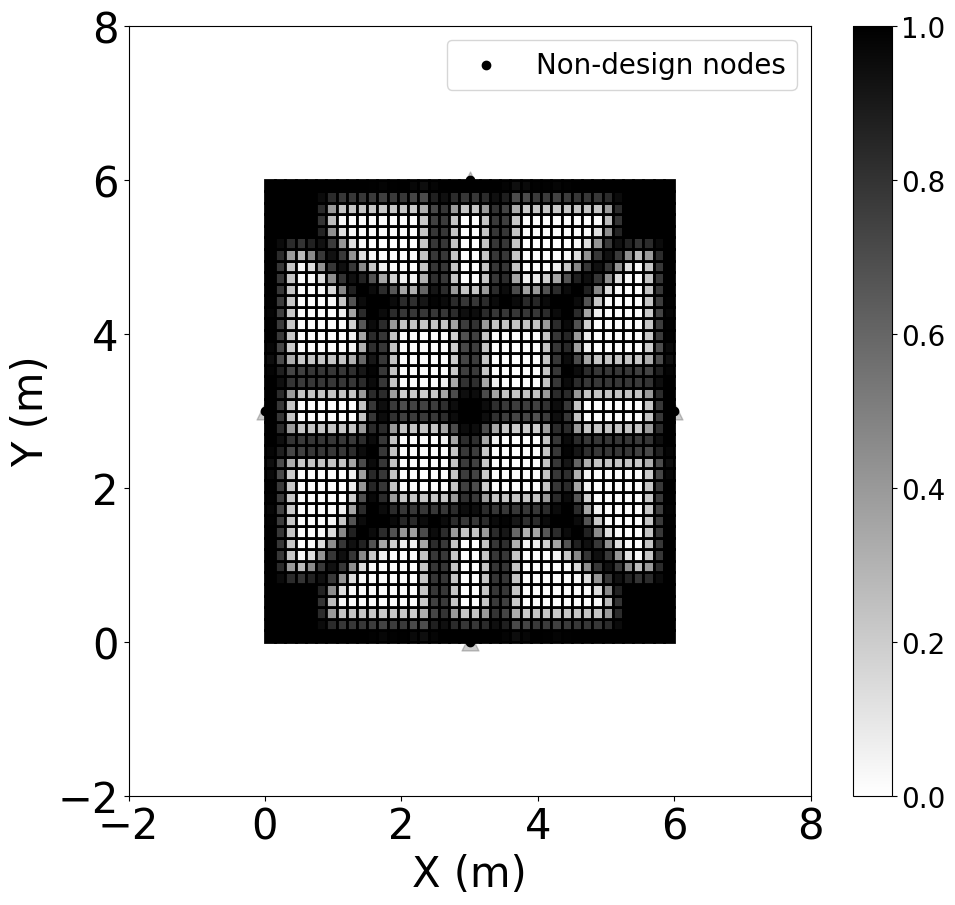

191th iteration, C = 1.6075944869648686 
192th iteration, C = 1.6019527790553398 
193th iteration, C = 1.6373054922294188 
194th iteration, C = 1.601964116313958 
195th iteration, C = 1.601772020290614 
799.9999884343424


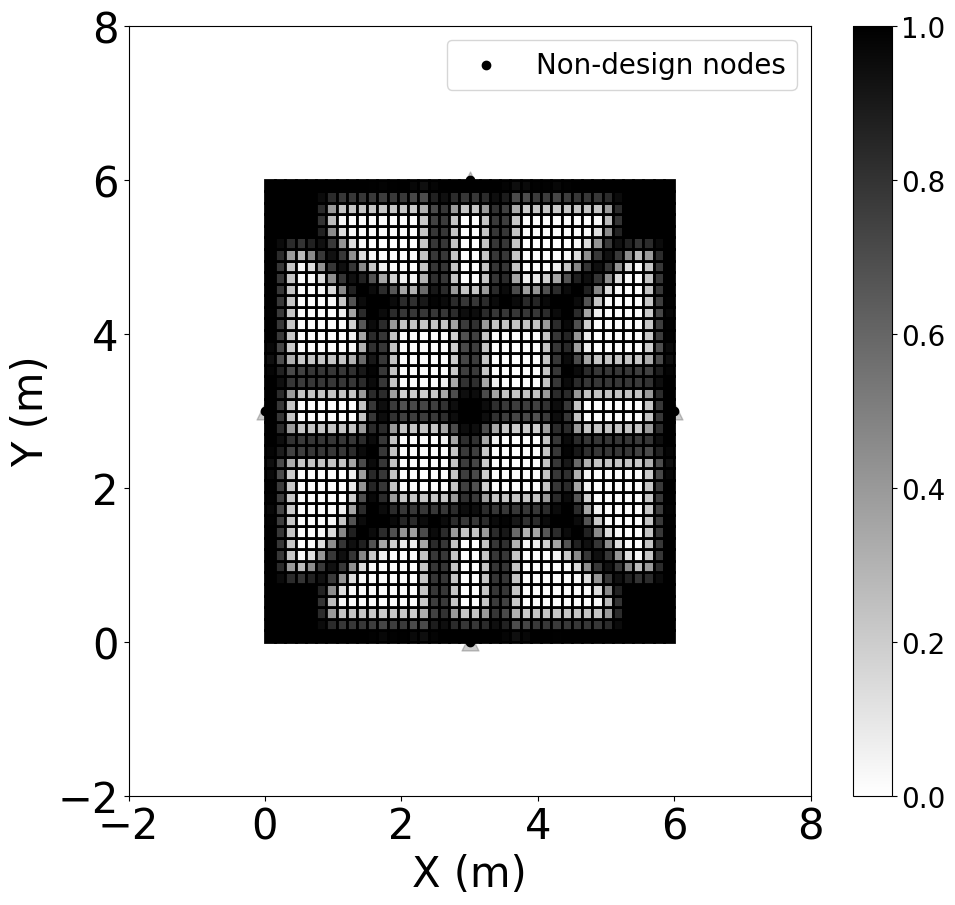

196th iteration, C = 1.6030029857770227 
197th iteration, C = 1.6015441407584767 
198th iteration, C = 1.6147277690719117 
199th iteration, C = 1.6012535800860495 
200th iteration, C = 1.6010090680791826 
799.9999494621067


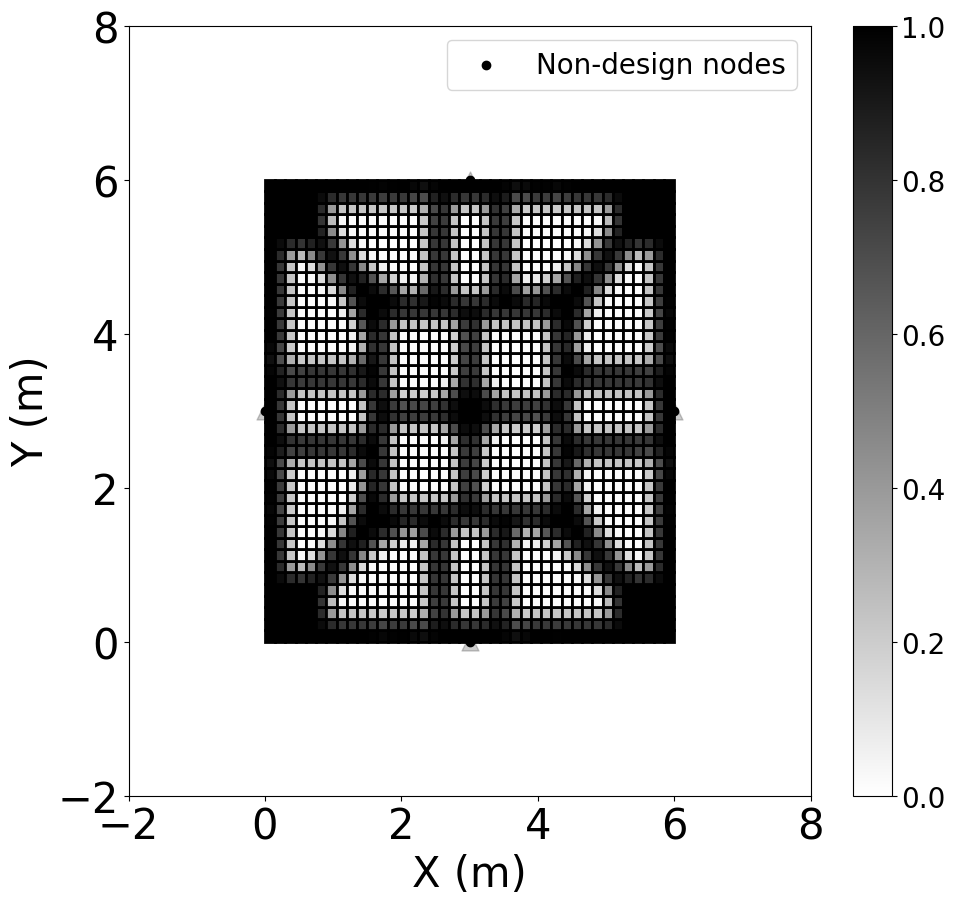

201th iteration, C = 1.6007910718268925 
202th iteration, C = 1.6018578570672573 
203th iteration, C = 1.6003520520433596 
204th iteration, C = 1.6898454741125437 
205th iteration, C = 1.6007084117482775 
799.9995435681999


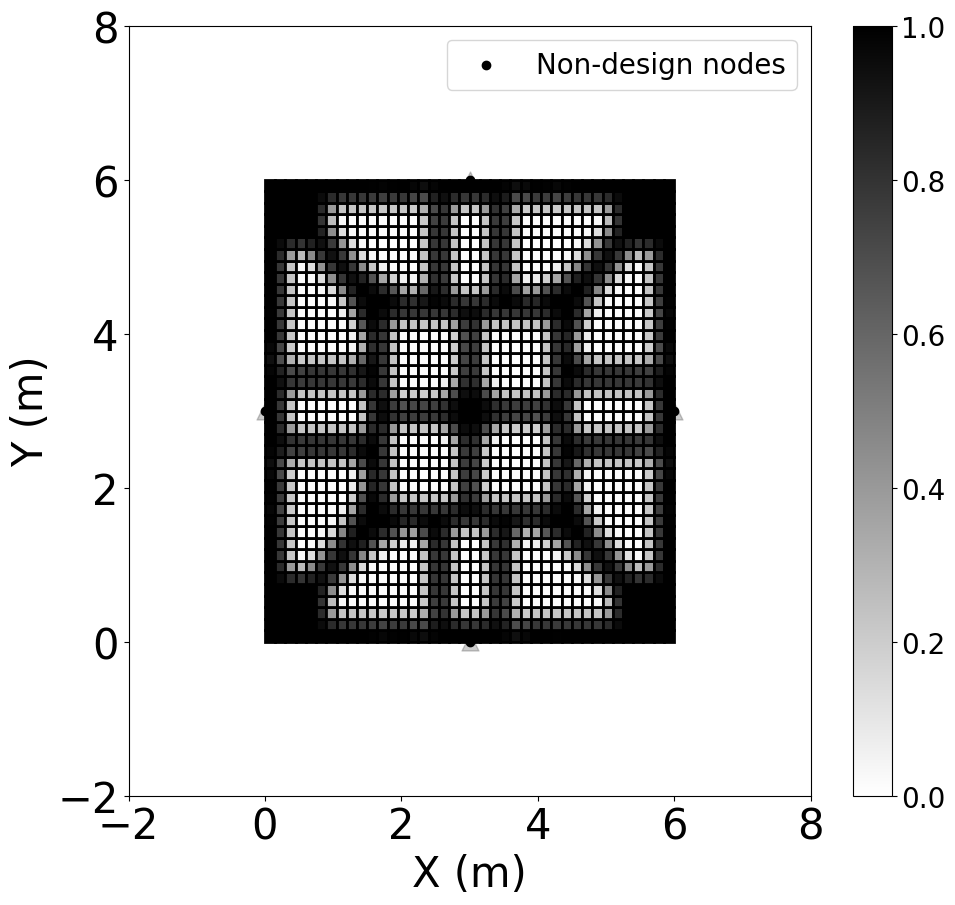

206th iteration, C = 1.6000452348546932 
207th iteration, C = 1.5997800532474338 
208th iteration, C = 1.6402390610056747 
209th iteration, C = 1.598673218436203 
210th iteration, C = 1.598248843660172 
799.9991490418881


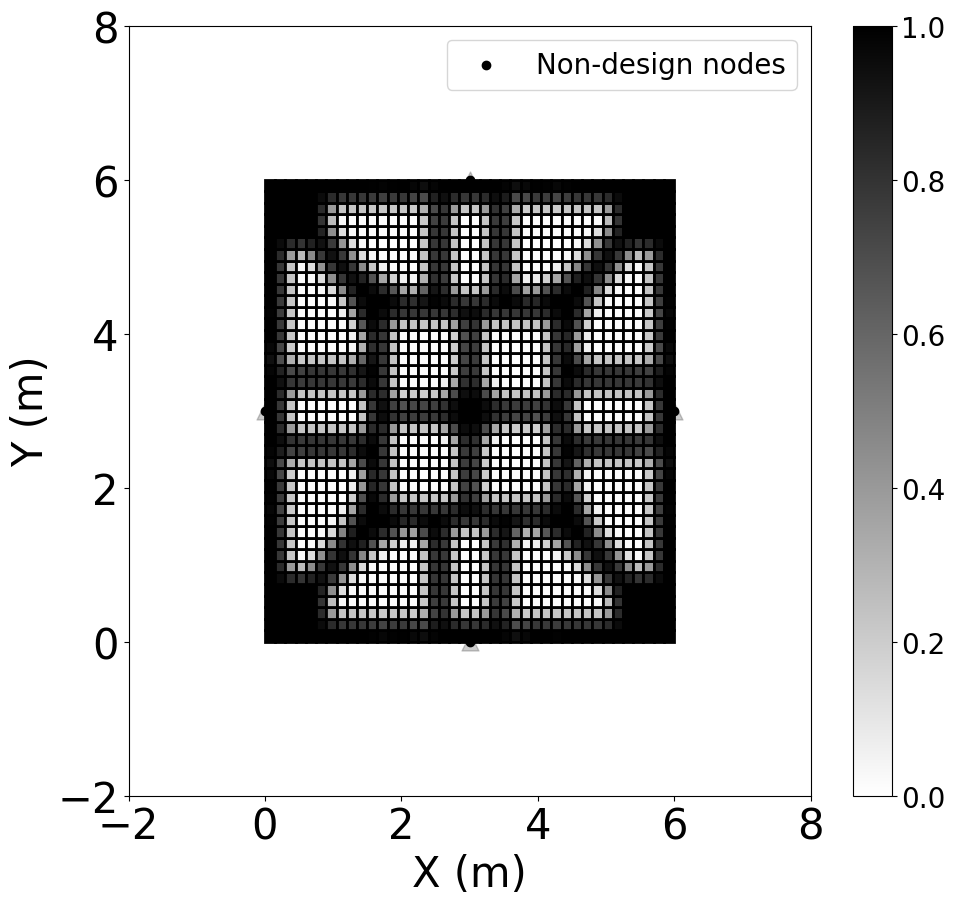

211th iteration, C = 1.5989597589275422 
212th iteration, C = 1.597780776770422 
213th iteration, C = 1.5984557653605032 
214th iteration, C = 1.5975893579886429 
215th iteration, C = 1.5976822500916212 
799.9999470839748


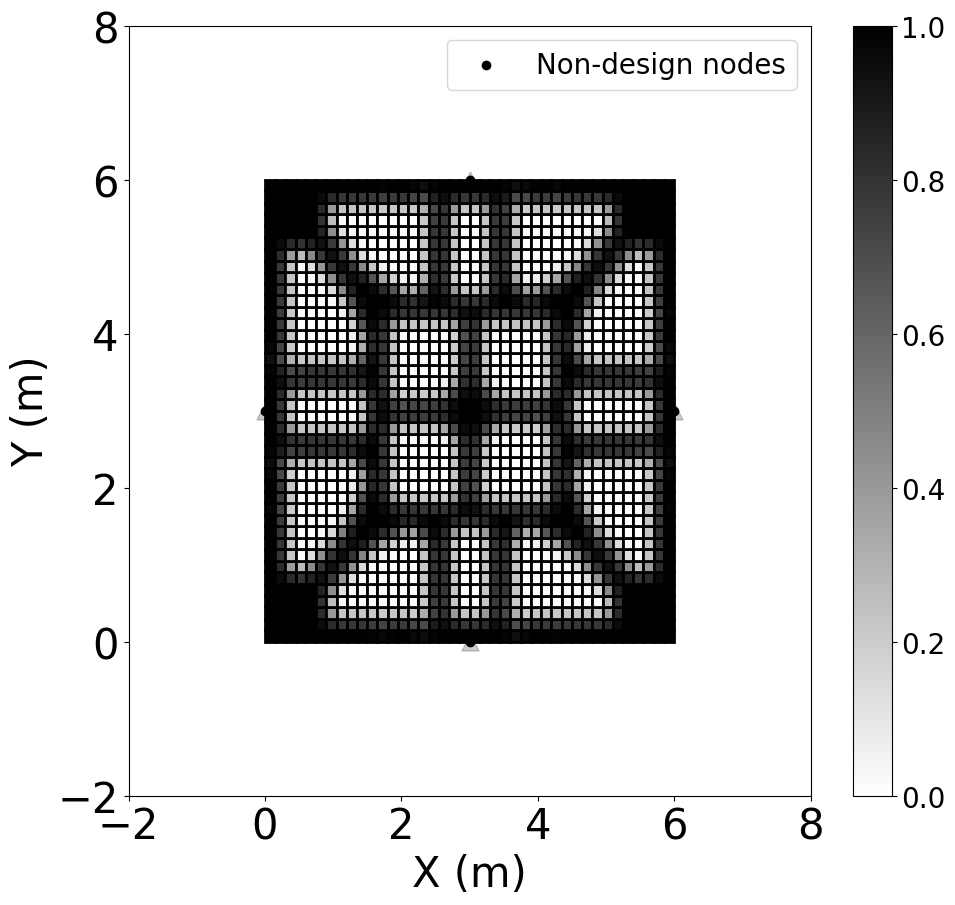

216th iteration, C = 1.5973939980408256 
217th iteration, C = 1.5972617376671048 
218th iteration, C = 1.6109275547272173 
219th iteration, C = 1.596761094085463 
220th iteration, C = 1.596681546395388 
799.9993755969736


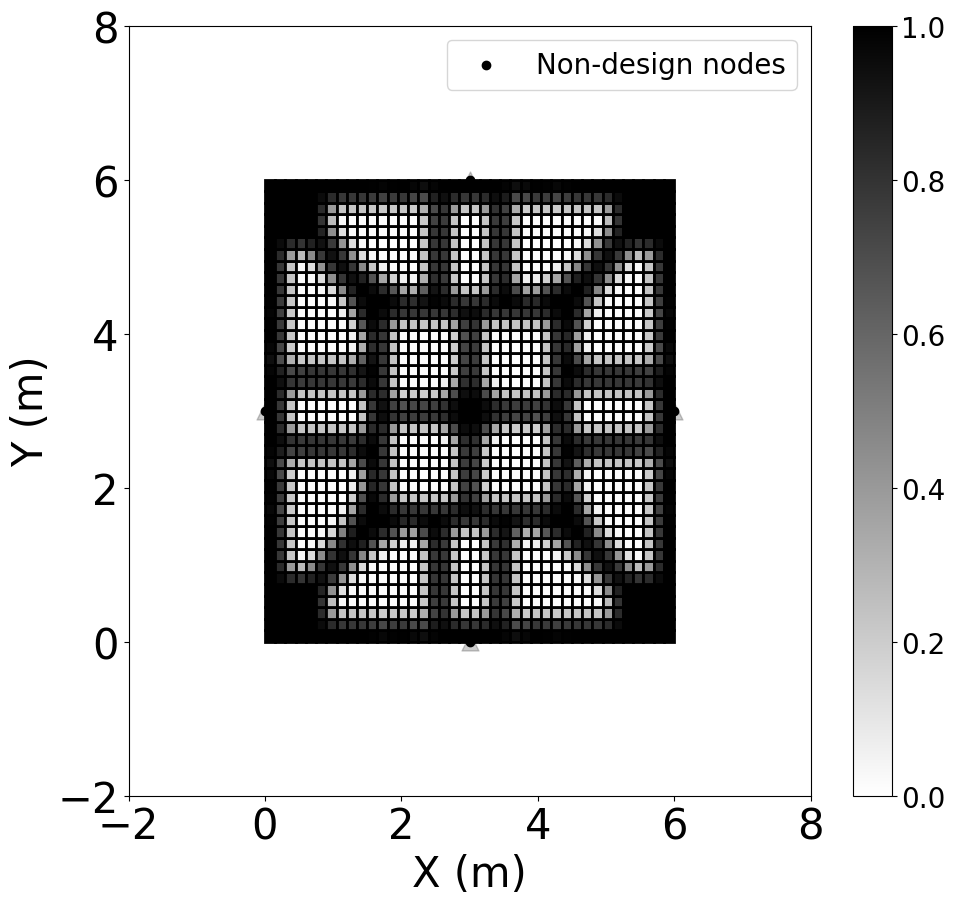

221th iteration, C = 1.5987155042614554 
222th iteration, C = 1.5963370241983974 
223th iteration, C = 1.5960173199322318 
224th iteration, C = 1.5991781996686434 
225th iteration, C = 1.5957024436982692 
799.9999654290833


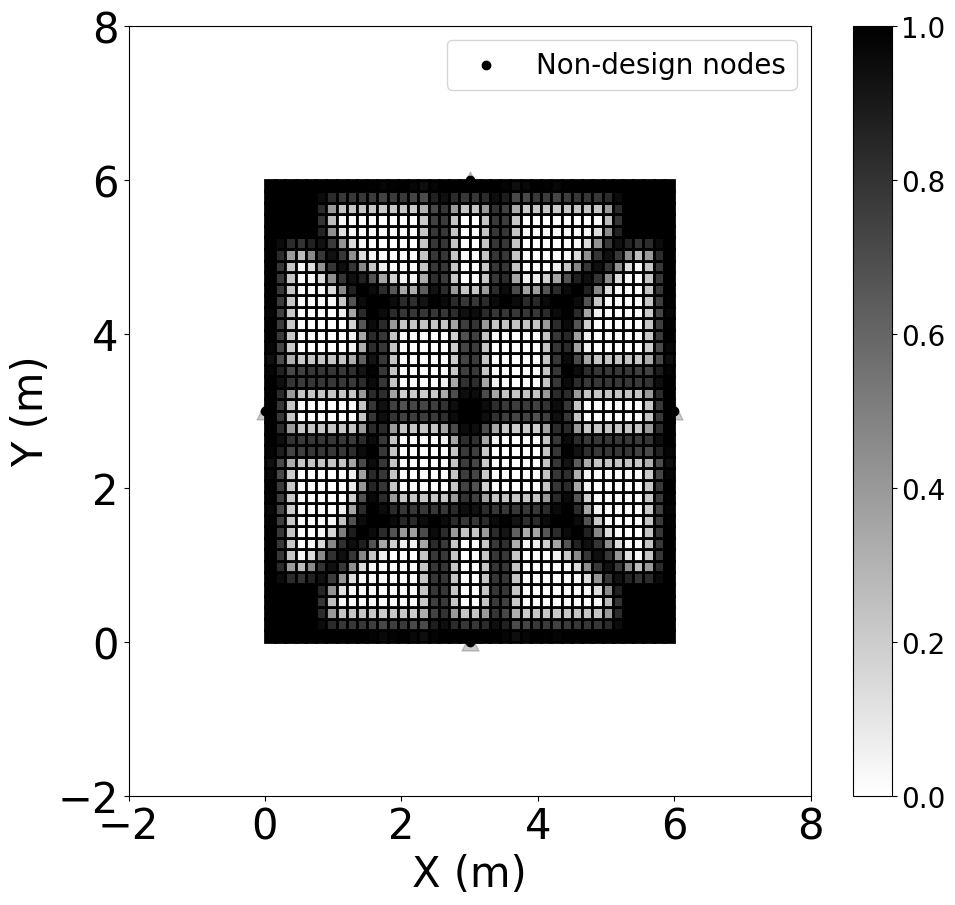

226th iteration, C = 1.5954180592178466 
227th iteration, C = 1.6031216197070768 
228th iteration, C = 1.5950660904709568 
229th iteration, C = 1.594842344053846 
230th iteration, C = 1.5974044921273385 
799.998903505573


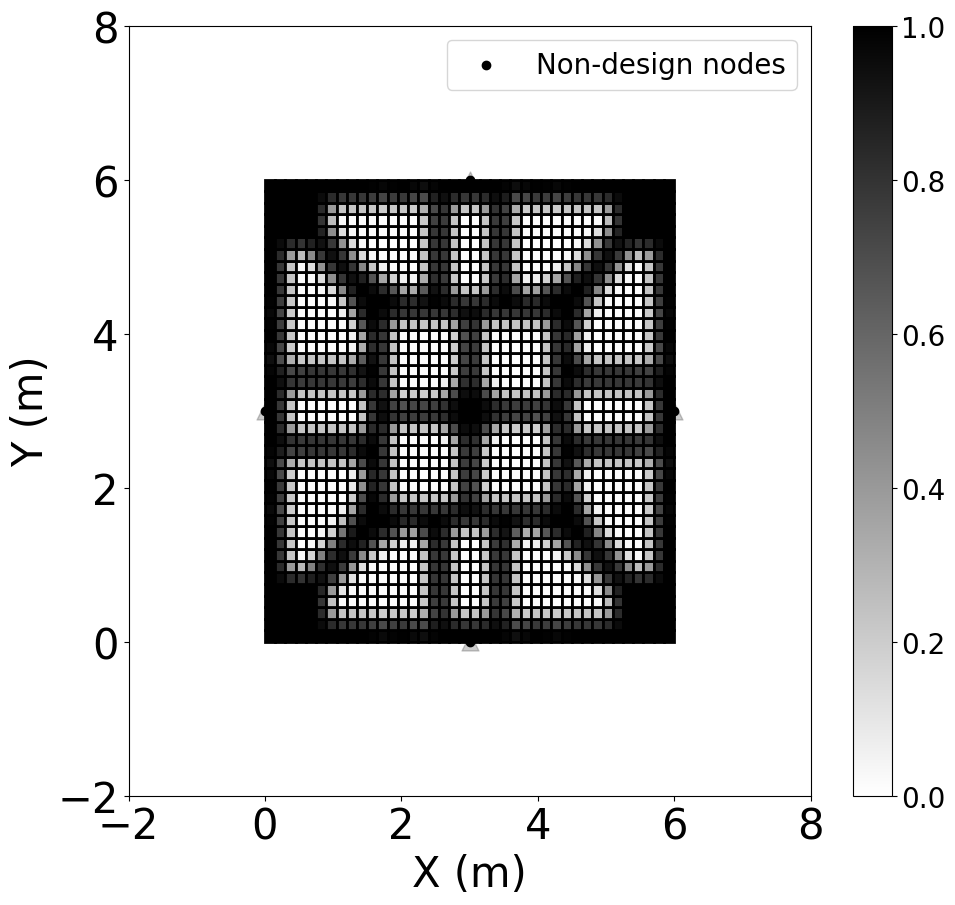

231th iteration, C = 1.5945416828732581 
232th iteration, C = 1.5945804834498576 
233th iteration, C = 1.594315146047246 
234th iteration, C = 1.6787251931452392 
235th iteration, C = 1.5956507420307267 
799.999142896812


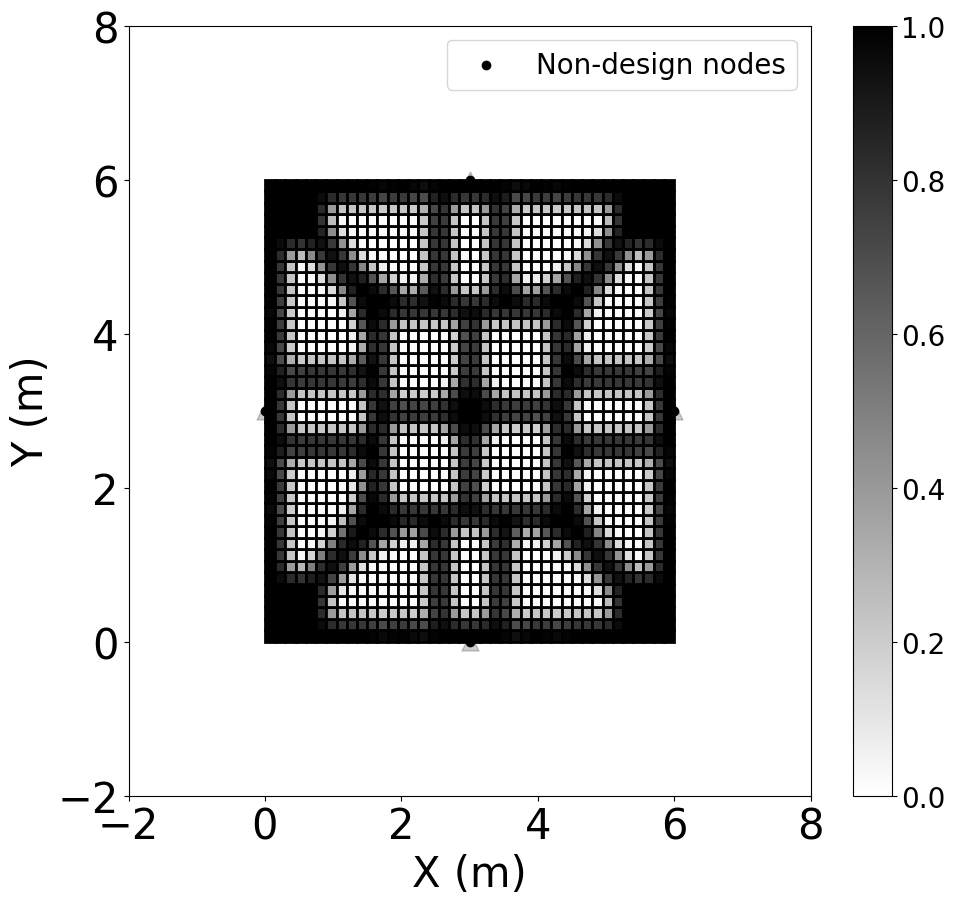

236th iteration, C = 1.5942017842619494 
237th iteration, C = 1.5942716445591123 
238th iteration, C = 1.5939977161596912 
239th iteration, C = 1.6332074873970204 
240th iteration, C = 1.5939377044411502 
799.9993917216444


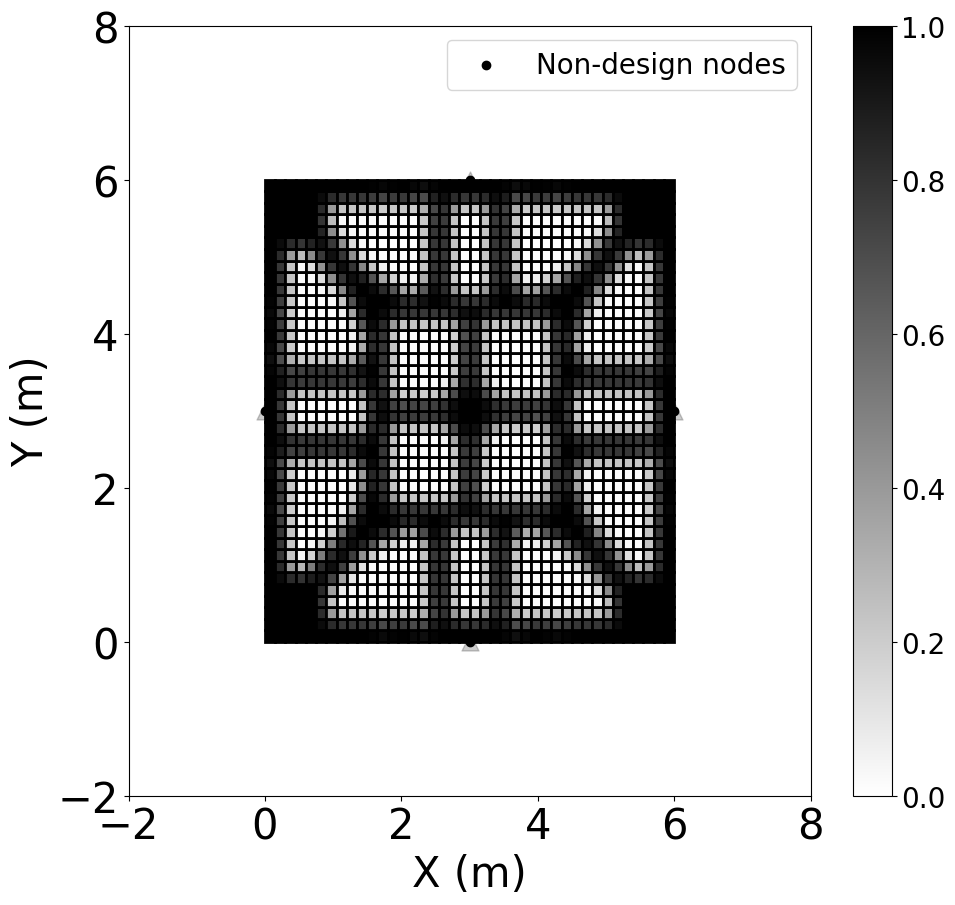

241th iteration, C = 1.5941510739293066 
242th iteration, C = 1.593618877257643 
243th iteration, C = 1.5932957884010504 
244th iteration, C = 1.6004009245411404 
245th iteration, C = 1.5929705888943153 
799.999950074395


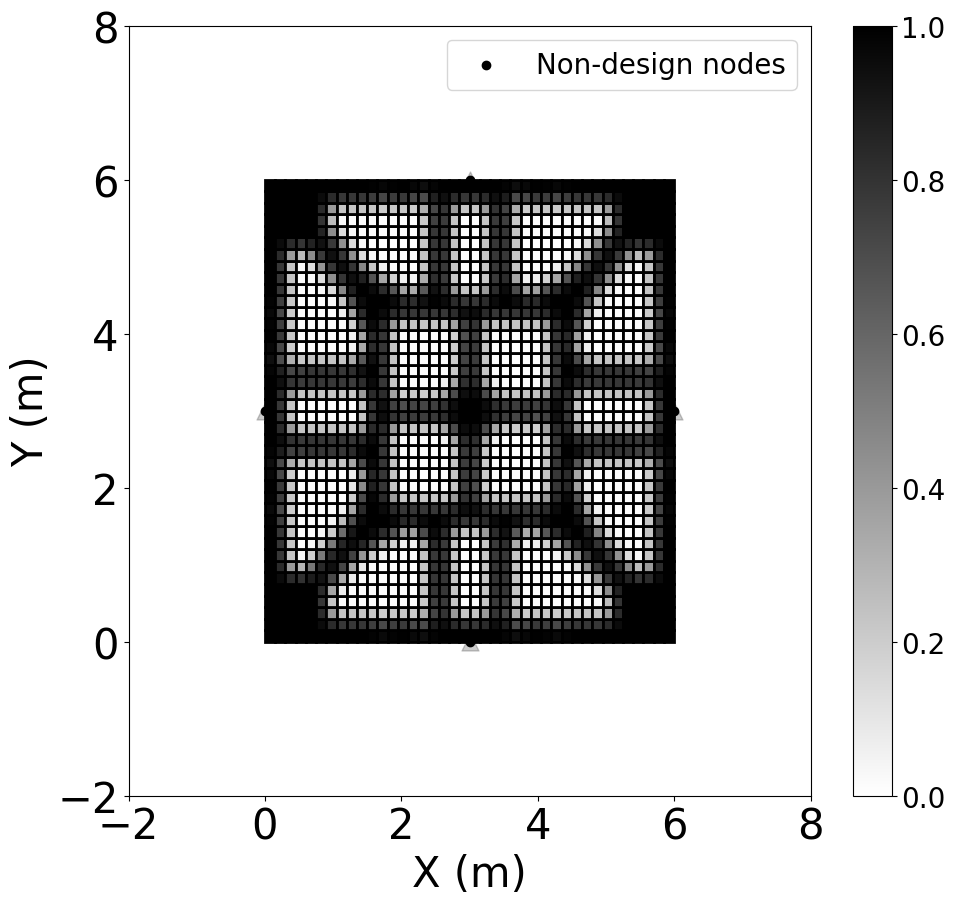

246th iteration, C = 1.5928696008417453 
247th iteration, C = 1.5924660809425744 
248th iteration, C = 1.7002848440918719 
249th iteration, C = 1.5947762165138175 
250th iteration, C = 1.5923306303179596 
799.9999132999792


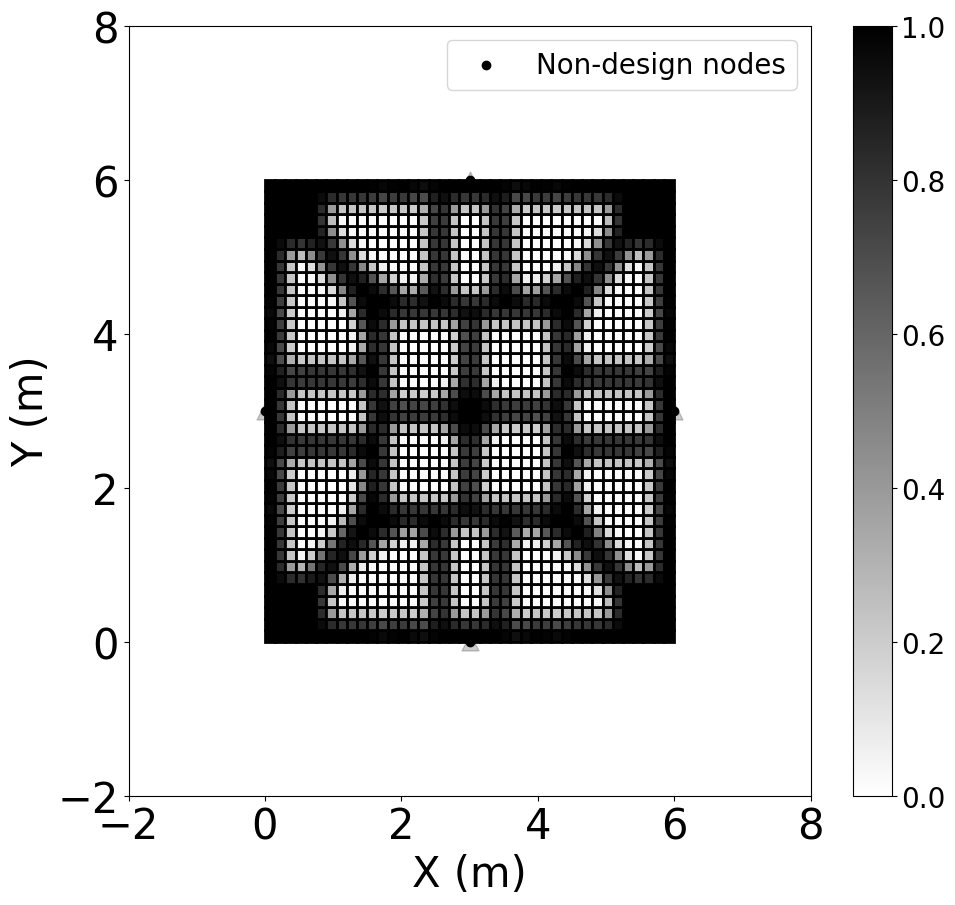

251th iteration, C = 1.5921703900815154 
252th iteration, C = 1.6051243411968106 
253th iteration, C = 1.5916326415346362 
254th iteration, C = 1.5912517833871989 
255th iteration, C = 1.5930345889284638 
799.9988787410703


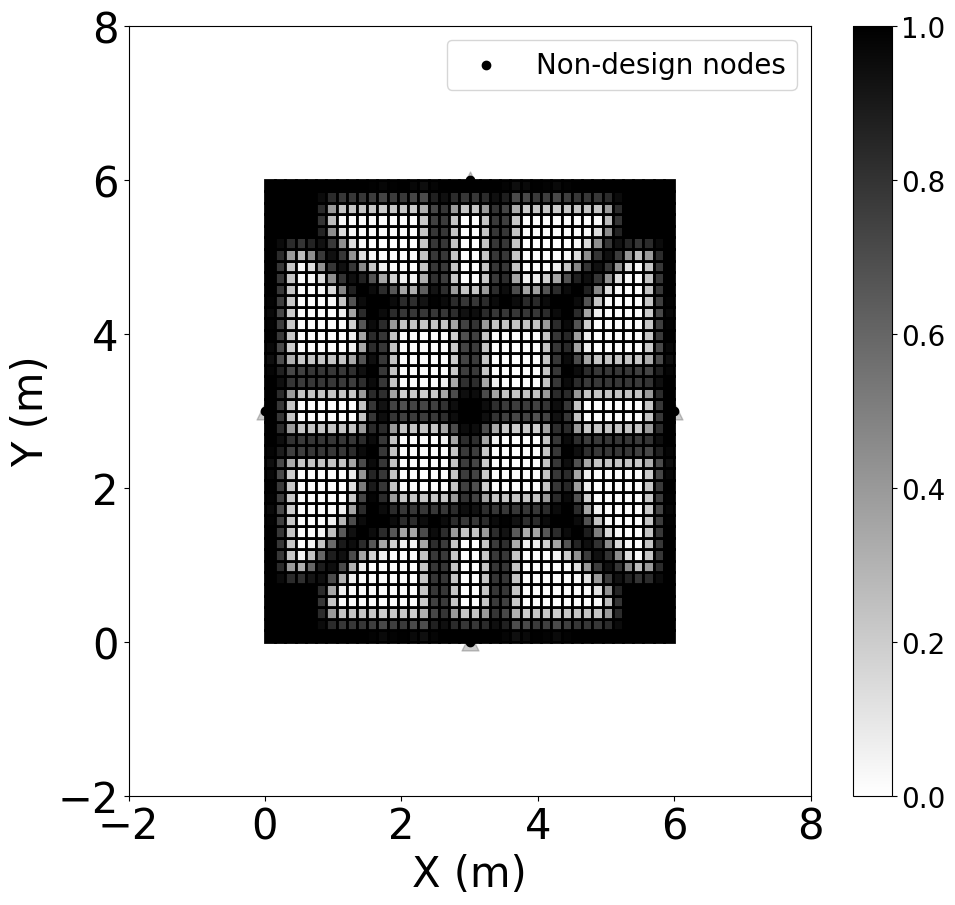

256th iteration, C = 1.591029518156492 
257th iteration, C = 1.5921022255056922 
258th iteration, C = 1.5908922789120286 
259th iteration, C = 1.5911960276805484 
260th iteration, C = 1.5907737707071747 
799.9999832430624


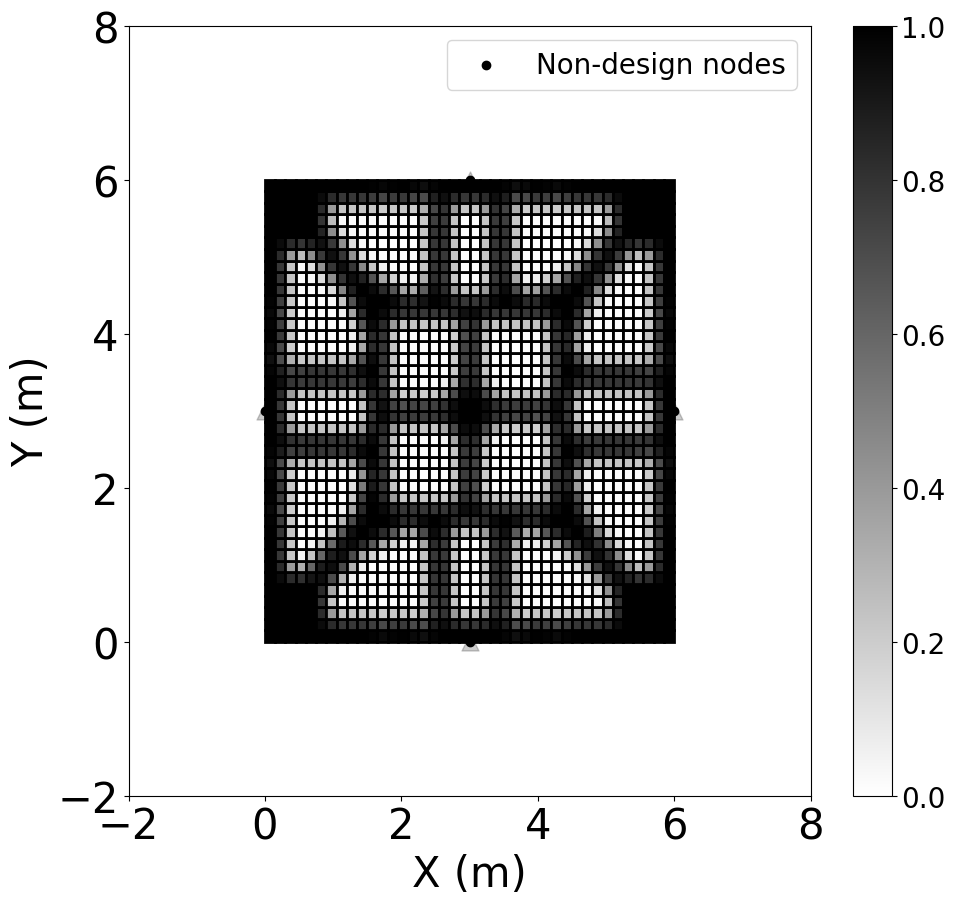

261th iteration, C = 1.5906219240697361 
262th iteration, C = 1.600459116206024 
263th iteration, C = 1.5903315295467508 
264th iteration, C = 1.5902818178292004 
265th iteration, C = 1.5900214344534656 
799.9994645817889


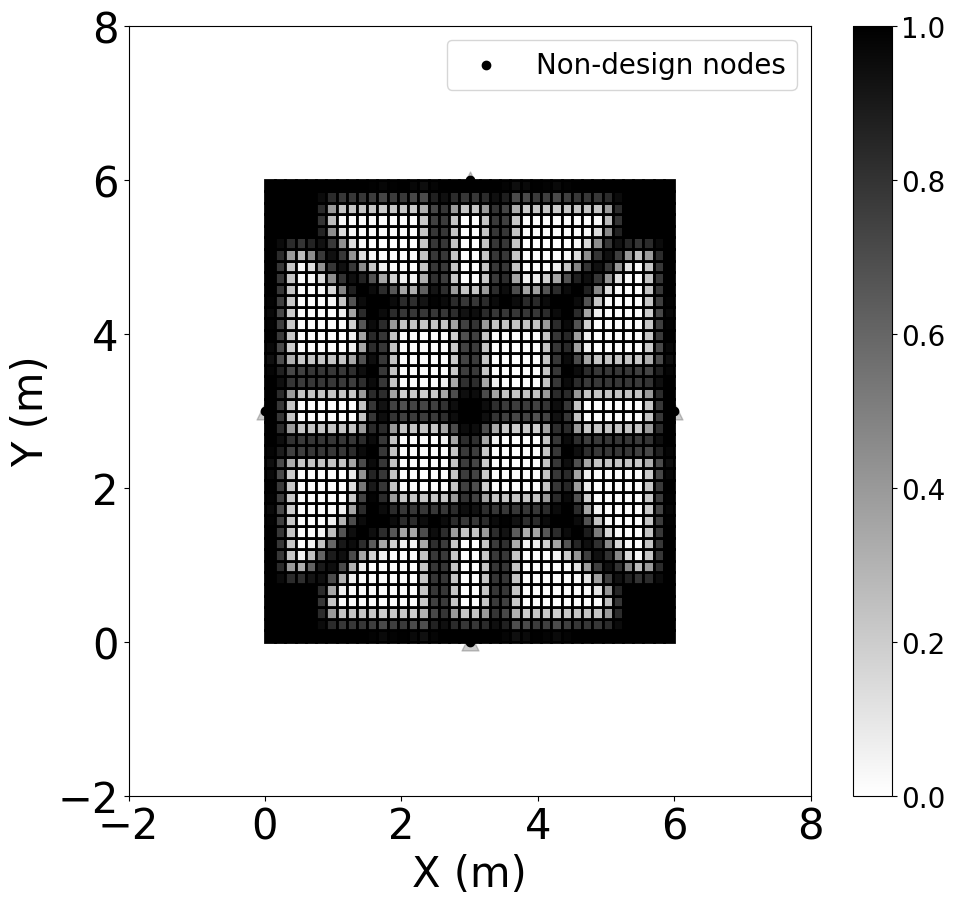

266th iteration, C = 1.6396500200679003 
267th iteration, C = 1.5907179178973478 
268th iteration, C = 1.5899006103015227 
269th iteration, C = 1.5898444048220146 
270th iteration, C = 1.598990002079014 
799.9980368171587


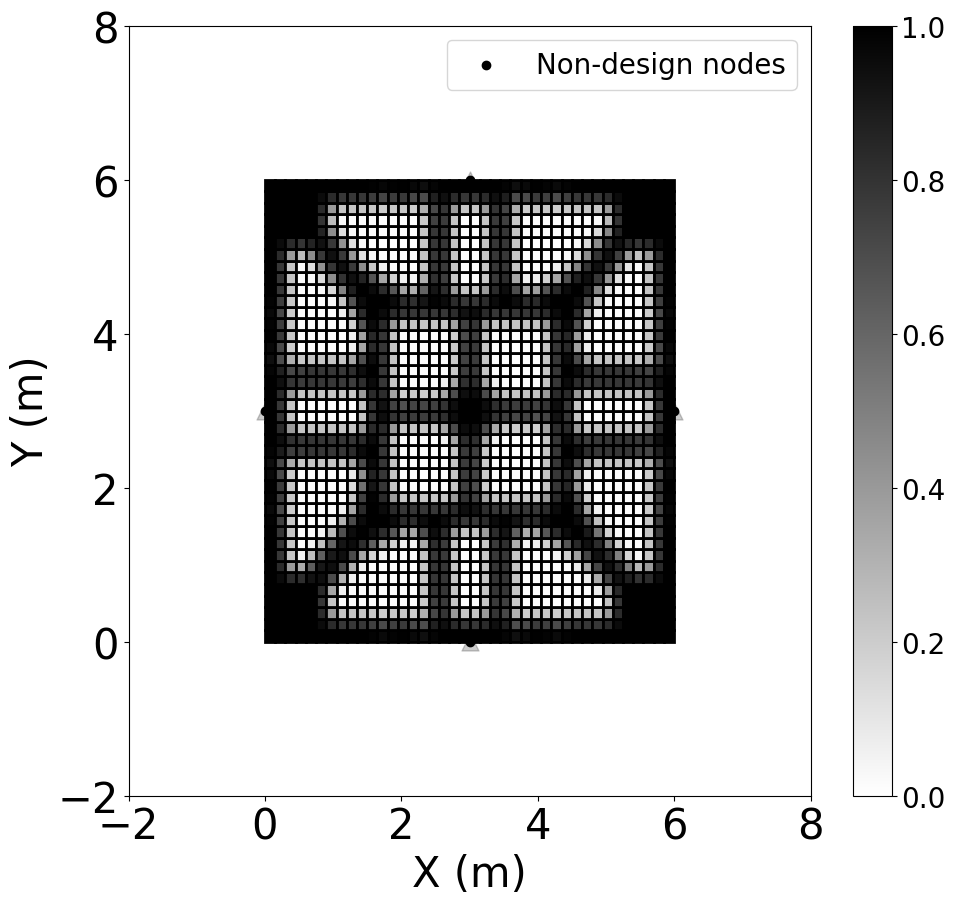

271th iteration, C = 1.58920595434327 
272th iteration, C = 1.589121612701478 
273th iteration, C = 1.5888453947890595 
274th iteration, C = 1.596388020245027 
275th iteration, C = 1.5886410084351303 
799.9999359061583


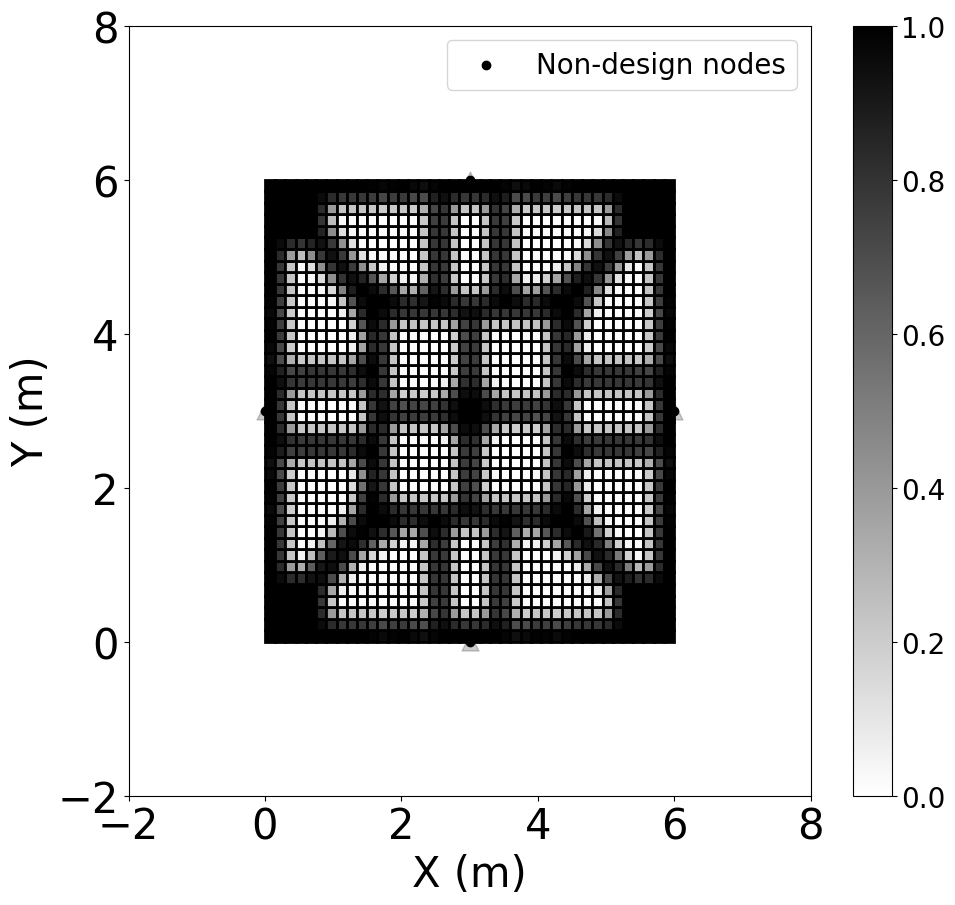

276th iteration, C = 1.5883363076136277 
277th iteration, C = 1.5943296061302528 
278th iteration, C = 1.5880810743264056 
279th iteration, C = 1.5884581683828196 
280th iteration, C = 1.5879454393048966 
799.9996487717589


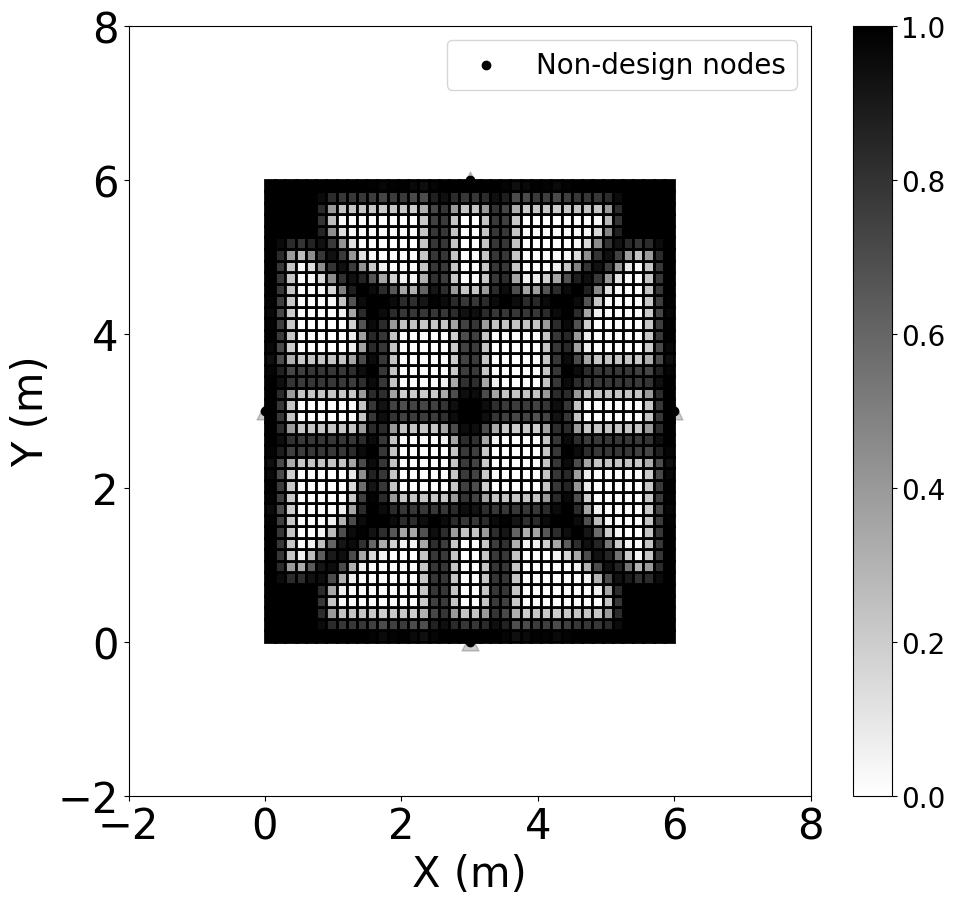

281th iteration, C = 1.6335614380924575 
282th iteration, C = 1.588068462265253 
283th iteration, C = 1.5878363219457117 
284th iteration, C = 1.5880575799189593 
285th iteration, C = 1.5876760036586153 
799.9995136826583


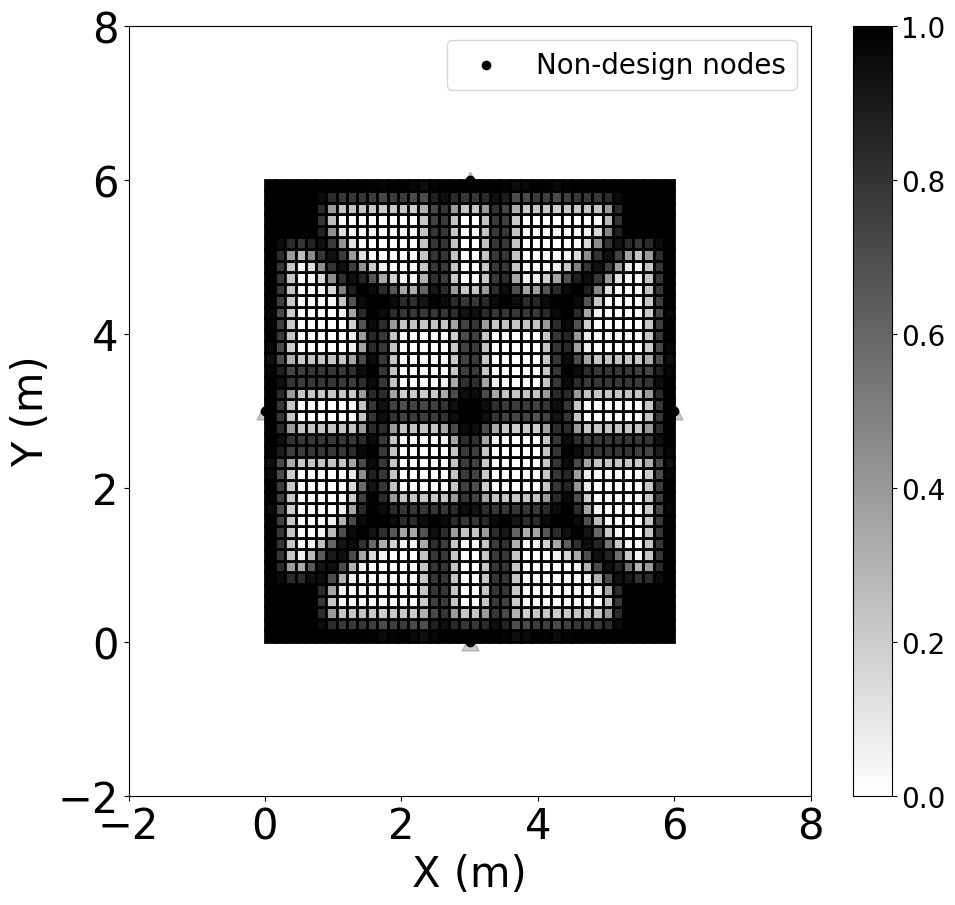

286th iteration, C = 1.6271327620979656 
287th iteration, C = 1.587788105255976 
288th iteration, C = 1.5875259396442258 
289th iteration, C = 1.5872469935691156 
290th iteration, C = 1.6005083372156614 
799.9969217365455


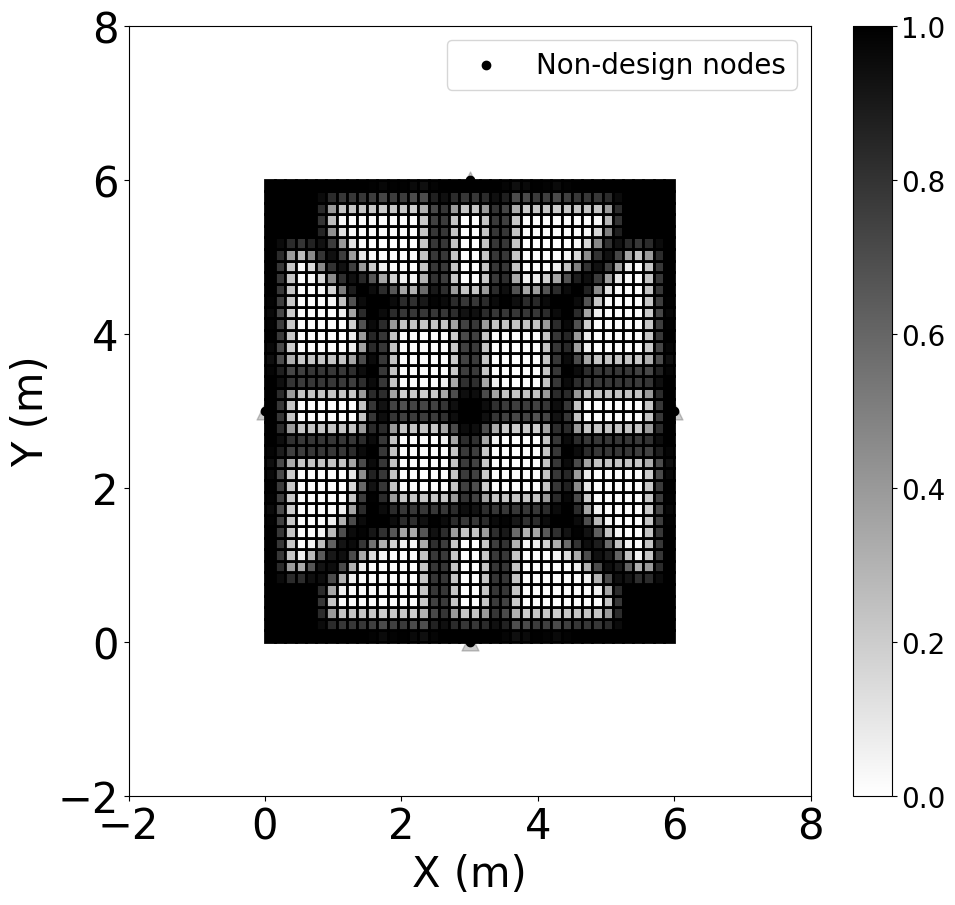

291th iteration, C = 1.5868442721588467 
292th iteration, C = 1.5866946223843803 
293th iteration, C = 1.590785210968109 
294th iteration, C = 1.586337762659421 
295th iteration, C = 1.5862348072744825 
799.9999666071235


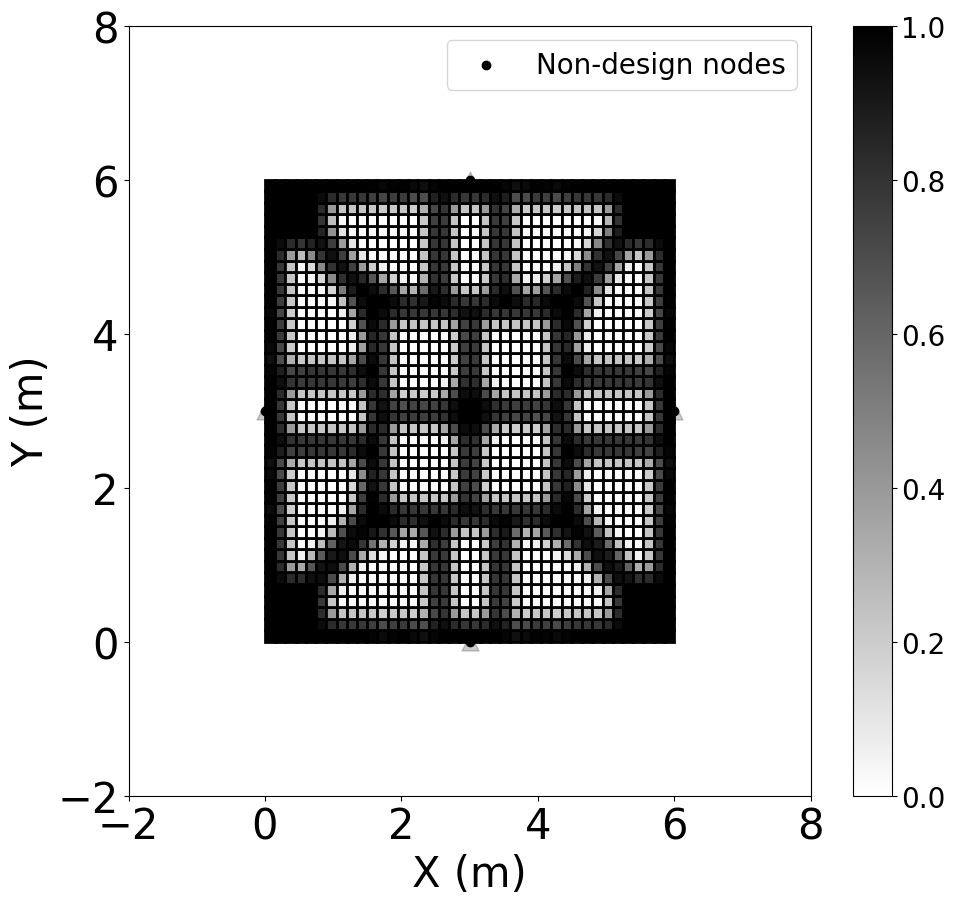

296th iteration, C = 1.5861362911760326 
297th iteration, C = 1.5882677696578378 
298th iteration, C = 1.5857890216944395 
299th iteration, C = 1.587788239406934 
300th iteration, C = 1.5856693874172059 
799.9998455834486


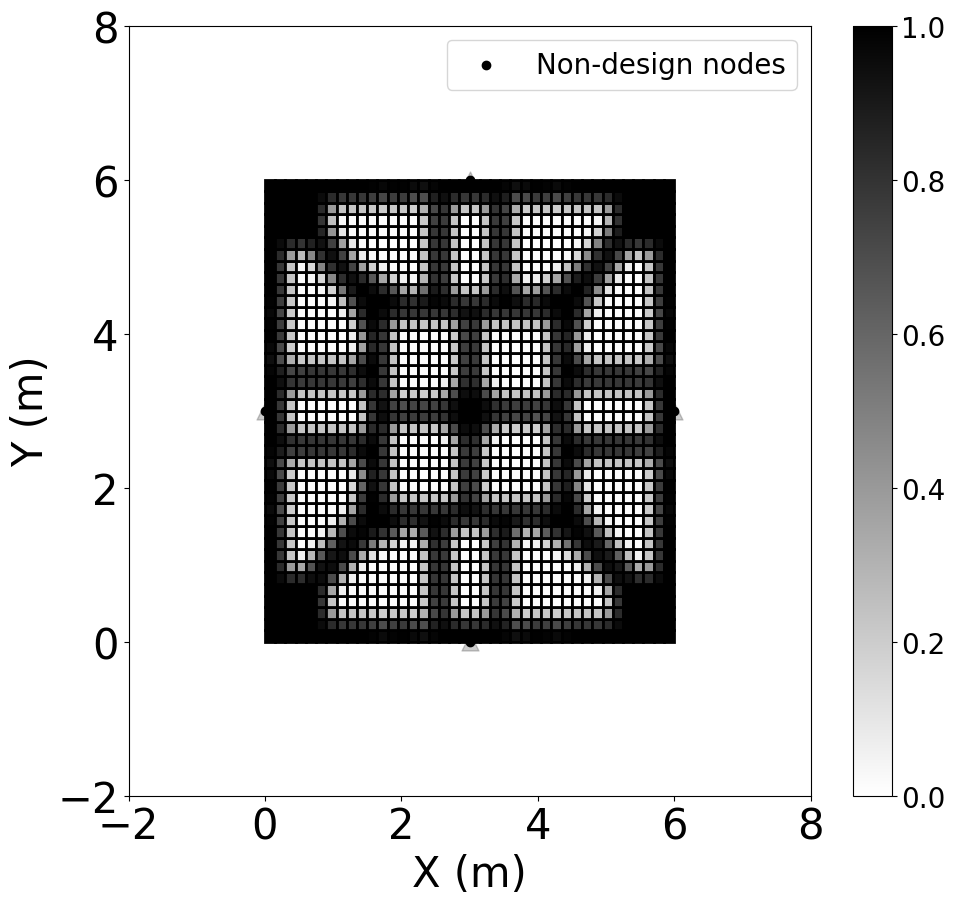

301th iteration, C = 1.5855843623806167 


In [28]:
n_dim = sso_model.parameter_values.shape[0]
opt = nlopt.opt(nlopt.LD_MMA, n_dim)
opt.set_min_objective(f)
opt.set_lower_bounds(0.01*np.ones(n_dim)) # Lower bounds
opt.set_upper_bounds(np.ones(n_dim)) #Upper bounds
opt.set_maxeval(300)
opt.add_inequality_constraint(fc)
#xopt = opt.optimize(xopt)
xopt = opt.optimize(x_ini)

Text(0, 0.5, 'Total strain energy (N$\\cdot$m)')

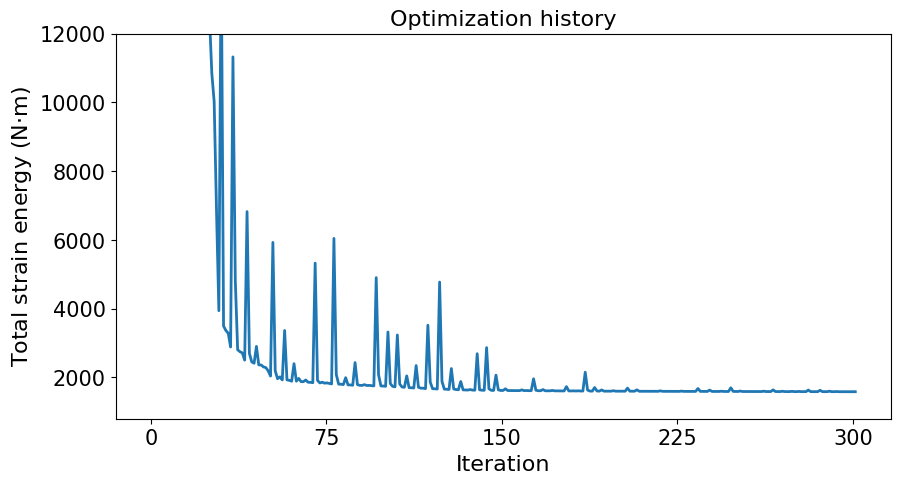

In [47]:

n_iter = np.array(C_hist).shape[0]
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(np.linspace(0,n_iter,n_iter),np.array(C_hist)*1000,linewidth=2)
plt.xticks(np.linspace(0,n_iter-1,5),fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim(800,12000)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (N$\cdot$m)',fontsize=16)

In [42]:
mu_opt = xopt[sso_model.nodeparameters_values.shape[0]:]
zs[design_nodes] = og_p(xopt[:sso_model.nodeparameters_values.shape[0]])
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

In [ ]:
np.max(objective_filter(xopt)[1][sso_model.nodeparameters_values.shape[0]:])

In [ ]:
np.min(objective_filter(xopt)[1][sso_model.nodeparameters_values.shape[0]:])

# Visualization

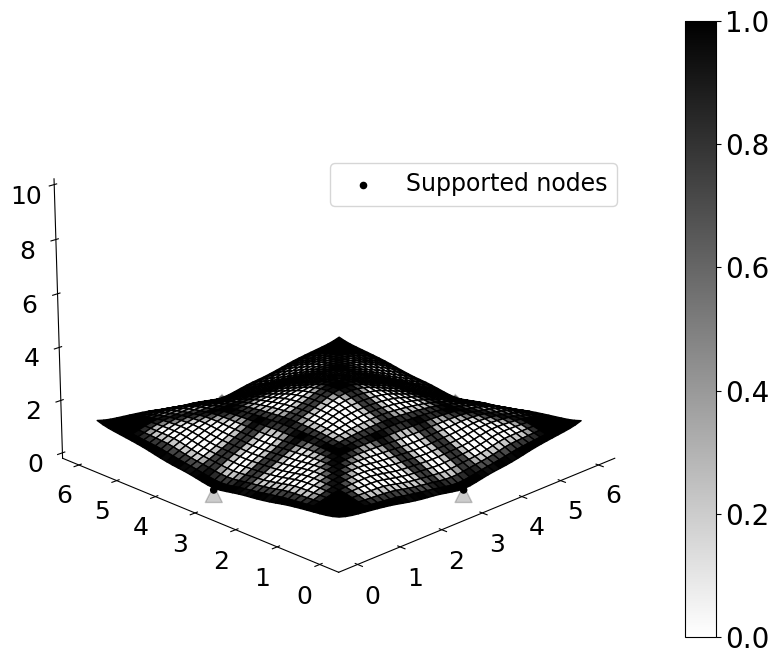

In [43]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

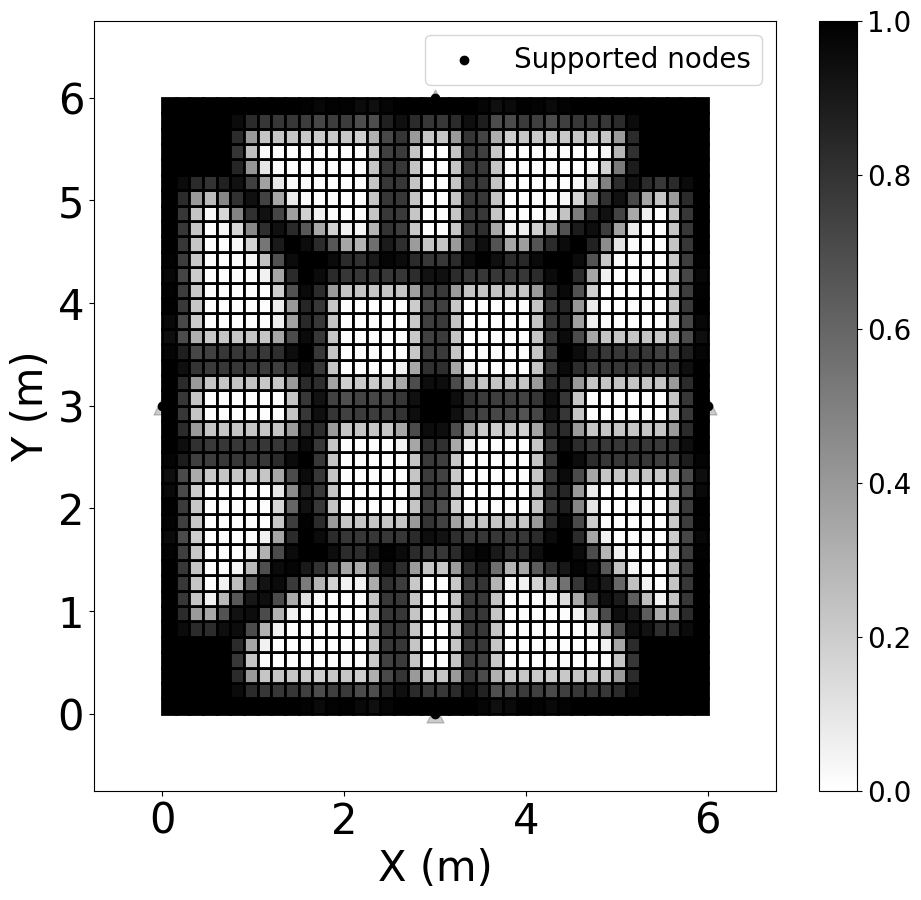

In [44]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

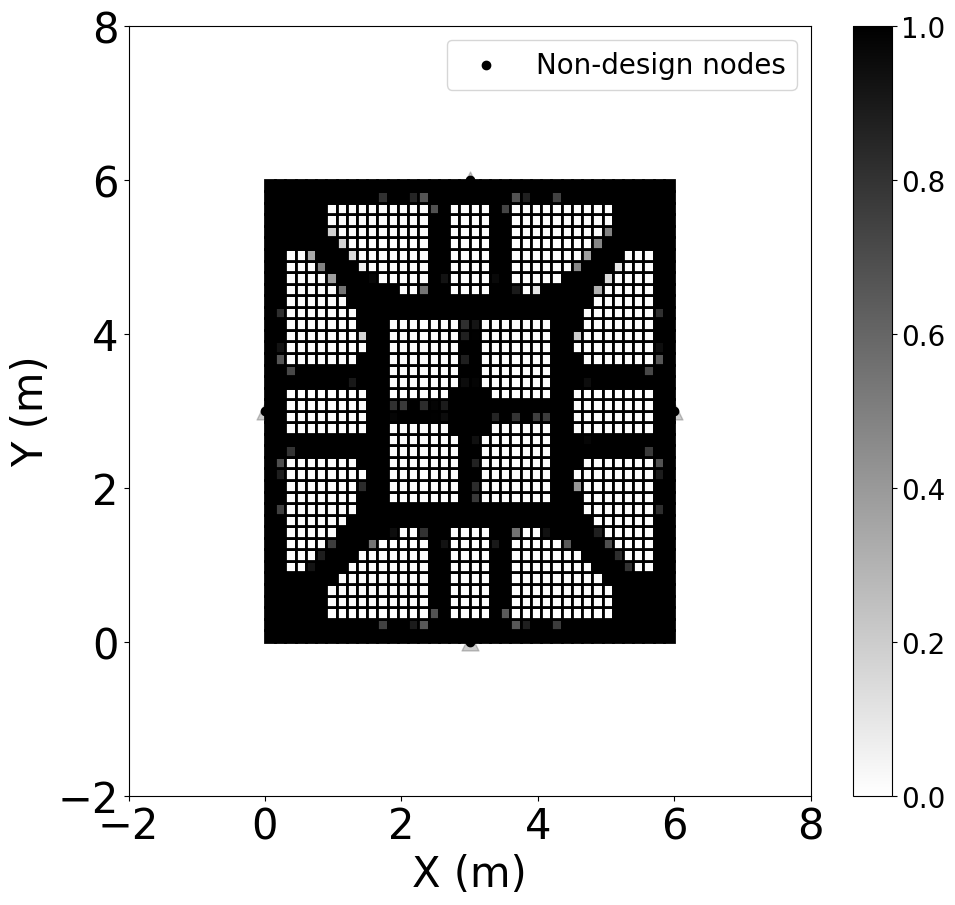

In [34]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [ ]:
mu_opt

In [ ]:
jnp.sum(mu_opt)

In [ ]:
0.5*sso_model.eleparameters_values.shape[0]

In [ ]:
mu_opt_filtered